# Analysis and prediction of Flights delays under different weather conditions

### Author : FRANCESCO IMERTI

## 1. [Flights cancellations and delays](#First-Section)
   ###         1.1  [Data gathering, wrangling and transformation](#First-Subsection)
   ### 1.2  [Exploratory Data Analysis](#Second-Subsection)
   ### 1.3  [Features Engineering](#Third-Subsection)
## 2. [Weather](#Second-Section)
   ###        2.1  [Datasets, data wrangling, and merging](#Fourth-Subsection)
   ### 2.2  [Exploratory Data Analysis](#Fifth-Subsection)
## 3.  [Machine Learning](#Third-Section)
   ### 3.1 [Prediction](#Sixth-Subsection)
   ### 3.2  [Classification](#Seventh-Subsection)
## 4. [Conlusion](#Fourth-Section)

In [1]:
#Libraries used in this notebook imported here

%matplotlib inline


import csv as csv 
import numpy as np
import pandas as pd

import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import statsmodels.api as sm
from scipy.stats import zscore
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics  import confusion_matrix
from sklearn.metrics  import classification_report
from sklearn.metrics import accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor  

pd.options.mode.chained_assignment = None

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#Functions definition

def get_time (col) :
#This function transforms a string column(variable col) in a datetime type column
    list1=[]

    for a in df_1[col] :
        list1.append("{0:04d}".format(int(a)))   # transformation of numbers in list of strings
   
    list2=[]
    list3=[]

    for a in list1 :
        list2.append(a[0:2])     #hours saved in a list of strings 
        list3.append(a[2:4])     #minutes saved in a list of strings 

    list2i= list(map(int, list2)) #transformation in list of int
    list3i= list(map(int, list3)) #transformation in list of int

    for i in range (len(list2i)) :
        if list2i[i]== 24 :
            list2i[i]=0
        df_1[col][i]= datetime.time(list2i[i], list3i[i])  #from int format to datetime format
    
    return df_1[col]   



def polynomial(x, a, b, c):
    #returns y values of a polynomial function of 2nd grade
    
    return a * x**2 +  b*x + c


def calculate_vif_(X, thresh=100):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables = np.delete(variables, maxloc)
            dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return X[cols[variables]]

## 1.<a  id='First-Section'>Flights cancellations and delays </a>
In this section the main dataset will be processed taking into account the main research questions.

###     1.1 <a  id='First-Subsection'> Data gathering, wrangling and transformation </a>
Data will be sampled, duplicates will be excluded, and missing value will be deleted or imputed. A special case in which missing data where related to the cancellation of the flights made me to split the dataset in two sub-datasets: one dataset gathers cancelled flights and the other all the remains instances.     

In [3]:
#The Dataset has roughly six million instancies. Sampling is required to perform the analysis in reasonable time
 
df_full=pd.read_csv('flights.csv')

print('The original Dataset contains:')
print('{} Istances    {} Attributes\n'.format(df_full.shape[0],df_full.shape[1]))


df=df_full.sample(frac=0.035)      # 3.5% of total istances randomly sampled without replacement

df.drop_duplicates(inplace=True)   # duplicates have been deleted

print('The sampled Dataset contains:')
print('{} Istances    {} Attributes'.format(df.shape[0],df.shape[1]))

df.to_csv('flights.sample.csv')  #Sampled dataset saved 


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The original Dataset contains:
5819079 Istances    31 Attributes

The sampled Dataset contains:
203668 Istances    31 Attributes


In [4]:
df=pd.read_csv('flights.sample.csv')

In [5]:
#DATA INFORMATION
print("Number of features in the sampled dataset :",df.shape[1])
print("Number of rows in the sampled dataset :",df.shape[0])
df.head()


Number of features in the sampled dataset : 32
Number of rows in the sampled dataset : 203668


,Unnamed: 0,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,1215107,2015,3,20,5,AA,187,N3LUAA,BOS,ORD,...,1335.0,-15.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,3612229,2015,8,13,4,UA,1119,N28457,LAX,DEN,...,857.0,-7.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,5768544,2015,12,28,1,MQ,3090,N644MQ,ORD,CMI,...,NaN,NaN,0,1,B,NaN,NaN,NaN,NaN,NaN
3,5526268,2015,12,13,7,B6,1109,N649JB,BOS,JAX,...,1116.0,-32.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2649351,2015,6,16,2,WN,3769,N8637A,MDW,PHX,...,1917.0,12.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#General information

df.rename({"Unnamed: 0":"a"}, axis=1, inplace=True)
df.drop(['a'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203668 entries, 0 to 203667
Data columns (total 31 columns):
YEAR                   203668 non-null int64
MONTH                  203668 non-null int64
DAY                    203668 non-null int64
DAY_OF_WEEK            203668 non-null int64
AIRLINE                203668 non-null object
FLIGHT_NUMBER          203668 non-null int64
TAIL_NUMBER            203170 non-null object
ORIGIN_AIRPORT         203668 non-null object
DESTINATION_AIRPORT    203668 non-null object
SCHEDULED_DEPARTURE    203668 non-null int64
DEPARTURE_TIME         200666 non-null float64
DEPARTURE_DELAY        200666 non-null float64
TAXI_OUT               200566 non-null float64
WHEELS_OFF             200566 non-null float64
SCHEDULED_TIME         203668 non-null float64
ELAPSED_TIME           200032 non-null float64
AIR_TIME               200032 non-null float64
DISTANCE               203668 non-null int64
WHEELS_ON              200448 non-null float64
TAXI_IN       

In [7]:
#DATA CLEANING

#Unnecessary columns have been deleted

col_todel=['DIVERTED','TAIL_NUMBER','FLIGHT_NUMBER','AIR_SYSTEM_DELAY','SECURITY_DELAY',
           'AIRLINE_DELAY','WHEELS_OFF','LATE_AIRCRAFT_DELAY','WHEELS_ON']

df_1=df.drop(col_todel,axis=1)

df_1.isnull().sum()

YEAR                        0
MONTH                       0
DAY                         0
DAY_OF_WEEK                 0
AIRLINE                     0
ORIGIN_AIRPORT              0
DESTINATION_AIRPORT         0
SCHEDULED_DEPARTURE         0
DEPARTURE_TIME           3002
DEPARTURE_DELAY          3002
TAXI_OUT                 3102
SCHEDULED_TIME              0
ELAPSED_TIME             3636
AIR_TIME                 3636
DISTANCE                    0
TAXI_IN                  3220
SCHEDULED_ARRIVAL           0
ARRIVAL_TIME             3220
ARRIVAL_DELAY            3636
CANCELLED                   0
CANCELLATION_REASON    200539
WEATHER_DELAY          166263
dtype: int64

In [8]:
#Data inputing of 'WEATHER_DELAY' to 0 in case arrival delay min is less than 15 min, missing values hve been considered to be 0

df_1['WEATHER_DELAY'][df_1['ARRIVAL_DELAY']<=16]=0 

In [9]:
#Check of missing values

df1_null = (df_1.isnull().sum()*100)/len(df_1)
print("Percentage of Missing Data in each feature:")
df1_null.sort_values(ascending=False)

Percentage of Missing Data in each feature:


CANCELLATION_REASON    98.463676
WEATHER_DELAY           1.785258
AIR_TIME                1.785258
ARRIVAL_DELAY           1.785258
ELAPSED_TIME            1.785258
ARRIVAL_TIME            1.581004
TAXI_IN                 1.581004
TAXI_OUT                1.523067
DEPARTURE_DELAY         1.473967
DEPARTURE_TIME          1.473967
DISTANCE                0.000000
SCHEDULED_ARRIVAL       0.000000
SCHEDULED_TIME          0.000000
CANCELLED               0.000000
SCHEDULED_DEPARTURE     0.000000
DESTINATION_AIRPORT     0.000000
ORIGIN_AIRPORT          0.000000
AIRLINE                 0.000000
DAY_OF_WEEK             0.000000
DAY                     0.000000
MONTH                   0.000000
YEAR                    0.000000
dtype: float64

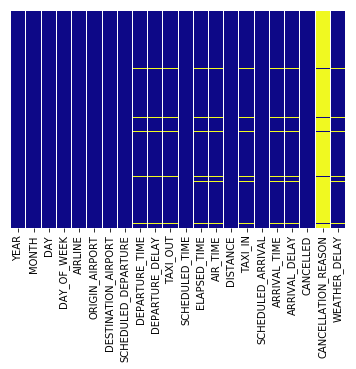

In [10]:
sns.heatmap(df_1.isnull(),yticklabels=False,cbar=False,cmap='plasma')

'Cancellation reason' has to many empty values, other attributes have less than 2% of missing data so we could safely delete the empty rows and the column. A closer look to missing values makes me see that are almost all related to the same rows, the only rows in which 'Cancellation reason' doesn't have any missing. 

In [11]:
#The rows presenting missing values are filtered and head and tail of the dataframe is printed out 
idx_canc=df_1['DEPARTURE_TIME'].isnull()

print(df_1[idx_canc].head())
print(df_1[idx_canc].tail())


     YEAR  MONTH  DAY  DAY_OF_WEEK AIRLINE ORIGIN_AIRPORT DESTINATION_AIRPORT  \
2    2015     12   28            1      MQ            ORD                 CMI   
22   2015      1    5            1      OO            SEA                 PDX   
78   2015     11   17            2      UA            DEN                 IAH   
94   2015      4    9            4      UA            ORD                 MCO   
503  2015      5    8            5      WN            LAX                 OAK   

     SCHEDULED_DEPARTURE  DEPARTURE_TIME  DEPARTURE_DELAY      ...        \
2                   1650             NaN              NaN      ...         
22                  1900             NaN              NaN      ...         
78                   705             NaN              NaN      ...         
94                  1045             NaN              NaN      ...         
503                 1235             NaN              NaN      ...         

     ELAPSED_TIME  AIR_TIME  DISTANCE  TAXI_IN  SCHEDULE

As supposed, values miss due to the fact that the flight was cancelled. We cannot have arrival time or air time if the airplane does not take off.



--------------------------------------------------------------------------------------------------------------------------------

DATA TRANSFORMATION: TIME SERIES 

In this dataset year, months, days, and times are saved in different columns as int or float. I merge those values in datetime objects. Doing so, merging other datasets or performing analysis in fixed periods of time will be easier. 

In [12]:
#DATE column and SCHEDULED_DEPARTURE transformation

print(df_1.isnull().sum())

df_1['DATE'] = pd.to_datetime(df_1[['YEAR','MONTH', 'DAY']])  #New column with date object
#df_1.reset_index(inplace=True)

#Time formatting
get_time('SCHEDULED_DEPARTURE') #this function could be used to modify not only 'SCHEDULED_DEPARTURE' 
                                #but SCHEDULED_ARRIVAL and other columns. 

YEAR                        0
MONTH                       0
DAY                         0
DAY_OF_WEEK                 0
AIRLINE                     0
ORIGIN_AIRPORT              0
DESTINATION_AIRPORT         0
SCHEDULED_DEPARTURE         0
DEPARTURE_TIME           3002
DEPARTURE_DELAY          3002
TAXI_OUT                 3102
SCHEDULED_TIME              0
ELAPSED_TIME             3636
AIR_TIME                 3636
DISTANCE                    0
TAXI_IN                  3220
SCHEDULED_ARRIVAL           0
ARRIVAL_TIME             3220
ARRIVAL_DELAY            3636
CANCELLED                   0
CANCELLATION_REASON    200539
WEATHER_DELAY            3636
dtype: int64


0         11:56:00
1         05:40:00
2         16:50:00
3         08:49:00
4         17:25:00
5         13:10:00
6         06:50:00
7         13:00:00
8         08:10:00
9         16:58:00
10        13:55:00
11        07:30:00
12        22:50:00
13        18:55:00
14        13:36:00
15        14:30:00
16        20:10:00
17        15:15:00
18        10:15:00
19        11:24:00
20        09:41:00
21        09:55:00
22        19:00:00
23        20:59:00
24        10:20:00
25        11:00:00
26        08:41:00
27        19:00:00
28        18:36:00
29        12:57:00
            ...   
203638    11:30:00
203639    11:45:00
203640    12:10:00
203641    10:15:00
203642    14:15:00
203643    13:15:00
203644    06:45:00
203645    19:45:00
203646    17:15:00
203647    21:50:00
203648    10:02:00
203649    16:39:00
203650    12:10:00
203651    12:58:00
203652    17:47:00
203653    15:58:00
203654    18:00:00
203655    14:22:00
203656    14:00:00
203657    06:40:00
203658    07:20:00
203659    22

In [13]:
#Column DATE_TIME combining DATE and SCHEDULED_DEPARTURE
lista=[]
for i,v in df_1[['DATE','SCHEDULED_DEPARTURE']].iterrows() :   #iteration over rows
    
        try :
            lista.append(datetime.datetime.combine(df_1['DATE'][i],df_1['SCHEDULED_DEPARTURE'][i]))
        except:
            lista.append('error')        #if something goes wrong lista appens 'error'

indices = [i for i, x in enumerate(lista) if x == "error"]   #test of lista to see if it'ok
print ('Errors during data transformation :  ', len(indices))

df_1['DATE_TIME']=lista
print(df_1.head())     #  SCHEDULED_DEPARTURE  DATE and DATE_TIME successfully created

Errors during data transformation :   0
   YEAR  MONTH  DAY  DAY_OF_WEEK AIRLINE ORIGIN_AIRPORT DESTINATION_AIRPORT  \
0  2015      3   20            5      AA            BOS                 ORD   
1  2015      8   13            4      UA            LAX                 DEN   
2  2015     12   28            1      MQ            ORD                 CMI   
3  2015     12   13            7      B6            BOS                 JAX   
4  2015      6   16            2      WN            MDW                 PHX   

  SCHEDULED_DEPARTURE  DEPARTURE_TIME  DEPARTURE_DELAY         ...          \
0            11:56:00          1153.0             -3.0         ...           
1            05:40:00           541.0              1.0         ...           
2            16:50:00             NaN              NaN         ...           
3            08:49:00           839.0            -10.0         ...           
4            17:25:00          1748.0             23.0         ...           

   DISTANCE  TAX

2 DATASETS
To handle missing values of flights the way I go is to split the dataset in two different ones. First one with only cancelled flights the other one with all other flights. I will first have a look to the first dataset trying to get some insights, but the main work will be focused on flight delays. 

In [14]:
#Dataset 1 with cancelled flights
df_canc=df_1[idx_canc]
df_canc.info()
df_canc.drop(['DEPARTURE_TIME','DEPARTURE_DELAY','TAXI_OUT','TAXI_IN','ELAPSED_TIME','AIR_TIME',
              'ARRIVAL_TIME','ARRIVAL_DELAY','WEATHER_DELAY'] ,axis=1,inplace=True)

print('\n',df_canc.isnull().sum())   # there are no missing values among attributes of interest


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3002 entries, 2 to 203624
Data columns (total 24 columns):
YEAR                   3002 non-null int64
MONTH                  3002 non-null int64
DAY                    3002 non-null int64
DAY_OF_WEEK            3002 non-null int64
AIRLINE                3002 non-null object
ORIGIN_AIRPORT         3002 non-null object
DESTINATION_AIRPORT    3002 non-null object
SCHEDULED_DEPARTURE    3002 non-null object
DEPARTURE_TIME         0 non-null float64
DEPARTURE_DELAY        0 non-null float64
TAXI_OUT               0 non-null float64
SCHEDULED_TIME         3002 non-null float64
ELAPSED_TIME           0 non-null float64
AIR_TIME               0 non-null float64
DISTANCE               3002 non-null int64
TAXI_IN                0 non-null float64
SCHEDULED_ARRIVAL      3002 non-null int64
ARRIVAL_TIME           0 non-null float64
ARRIVAL_DELAY          0 non-null float64
CANCELLED              3002 non-null int64
CANCELLATION_REASON    3002 non-n

In [15]:
#df_2 will be used for delays. I can 

boolean =df_1['ARRIVAL_DELAY'].isnull()
index=df.index[boolean].tolist()
df_2=df_1.drop(index)    
df_2.drop(['CANCELLATION_REASON','CANCELLED'],axis=1,inplace=True)
print(df_2.isnull().sum())

YEAR                   0
MONTH                  0
DAY                    0
DAY_OF_WEEK            0
AIRLINE                0
ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
SCHEDULED_DEPARTURE    0
DEPARTURE_TIME         0
DEPARTURE_DELAY        0
TAXI_OUT               0
SCHEDULED_TIME         0
ELAPSED_TIME           0
AIR_TIME               0
DISTANCE               0
TAXI_IN                0
SCHEDULED_ARRIVAL      0
ARRIVAL_TIME           0
ARRIVAL_DELAY          0
WEATHER_DELAY          0
DATE                   0
DATE_TIME              0
dtype: int64


In [16]:
#AIRPORTS AND AIRLINE DATASETS MERGED to the cancellations dataset
df_ports=pd.read_csv('airports.csv')   # airports database
df_airlines=pd.read_csv('airlines.csv') # airlines database

df_canc2=df_canc.merge(df_ports[['IATA_CODE','CITY','LATITUDE','LONGITUDE']],left_on='ORIGIN_AIRPORT', right_on='IATA_CODE')
df_canc_end=df_canc2.merge(df_airlines,left_on='AIRLINE',right_on='IATA_CODE')
df_canc_end.drop(['IATA_CODE_y'],axis=1,inplace=True)
df_canc_end.rename({"AIRLINE_x":"AIRLINE_CODE"}, axis=1, inplace=True)
df_canc_end.rename({"AIRLINE_x":"AIRLINE_CODE"}, axis=1, inplace=True)
df_canc_end.rename({"AIRLINE_y":"AIRLINE"}, axis=1, inplace=True)
df_canc_end.rename({"IATA_CODE_x":"IATA_CODE"}, axis=1, inplace=True)
print(df_canc_end.head())

   YEAR  MONTH  DAY  DAY_OF_WEEK AIRLINE_CODE ORIGIN_AIRPORT  \
0  2015     12   28            1           MQ            ORD   
1  2015      1    8            4           MQ            ORD   
2  2015      1    3            6           MQ            ORD   
3  2015      6   12            5           MQ            ORD   
4  2015      2   15            7           MQ            ORD   

  DESTINATION_AIRPORT SCHEDULED_DEPARTURE  SCHEDULED_TIME  DISTANCE  \
0                 CMI            16:50:00            57.0       135   
1                 SDF            11:00:00            72.0       287   
2                 OMA            15:45:00            93.0       416   
3                 XNA            16:52:00           117.0       522   
4                 SUX            19:20:00            95.0       436   

   SCHEDULED_ARRIVAL  CANCELLED CANCELLATION_REASON       DATE  \
0               1747          1                   B 2015-12-28   
1               1312          1                   C 2015

###     1.2  <a  id='Second-Subsection'> Exploratory Data Analysis </a>

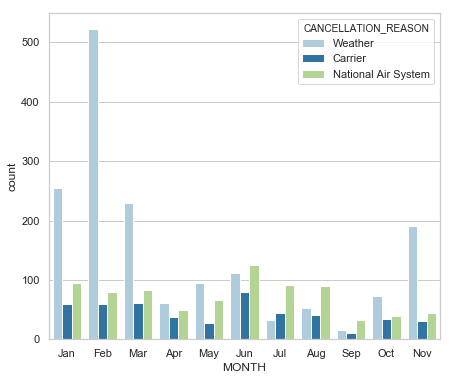

In [17]:
#CANCELLATIONS Dataset
#distribution of flights cancelled throughout the year
sns.set(style="whitegrid")
plt.figure(figsize=(7,6))
g=sns.countplot(x="MONTH", hue="CANCELLATION_REASON",palette="Paired", 
                data=df_canc_end)

legend = g.legend_

new_labels = ['Weather','Carrier','National Air System']
for t, l in zip(legend.texts, new_labels): 
    t.set_text(l)

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
g.set_xticklabels(months);


Flights cancelled for weather reason account for more than 50% of total cancellations, this phenomenon is accentuated in winter. Cancellations due to the national air system happened more in june than in the other periods of the year.

AIRLINES
UA :   United Air Lines Inc.
AA :   American Airlines Inc.
US :   US Airways Inc.
F9 :   Frontier Airlines Inc.
B6 :   JetBlue Airways
OO :   Skywest Airlines Inc.
AS :   Alaska Airlines Inc.
NK :   Spirit Air Lines
WN :   Southwest Airlines Co.
DL :   Delta Air Lines Inc.
EV :   Atlantic Southeast Airlines
HA :   Hawaiian Airlines Inc.
MQ :   American Eagle Airlines Inc.
VX :   Virgin America




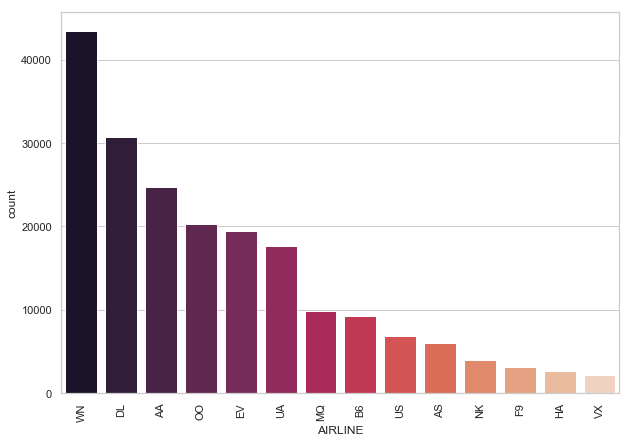

In [18]:
#Airlines data exploration, count of flights performed by each company 
A_dict = df_airlines.set_index('IATA_CODE')['AIRLINE'].to_dict()


print('AIRLINES')
for key, value in A_dict.items():
    print ('{} :   {}'.format(key, value))

df_2['AIRLINE_names']=df_2['AIRLINE'].replace(A_dict) 
print('\n')
df_2.head()

plt.figure(figsize=(10,7))
g=sns.countplot(x='AIRLINE', data=df_2, palette="rocket", order = df_2['AIRLINE'].value_counts().index)
g.set_xticklabels(g.get_xticklabels(),rotation=90);

It can be noticed a huge difference in terms of flights per year, is this factor affecting companies' time delay ? 
Airlines delays are shown below.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


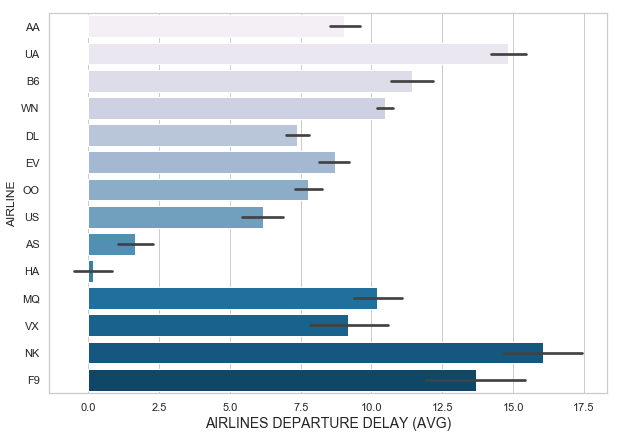

In [19]:
plt.figure(figsize=(10,7))
ax1=sns.barplot(y="AIRLINE", x="DEPARTURE_DELAY",data=df_2,palette='PuBu')
plt.xlabel('AIRLINES DEPARTURE DELAY (AVG)', fontsize=14)
plt.show()


From the bar chart it can be noticed that there is no correlation between company size and delays. Spirit Air Lines (NK) and Hawaiian Airlines Inc.(HA) in 2015 had same number of total flights and a large difference in terms of Departure delay (mean).



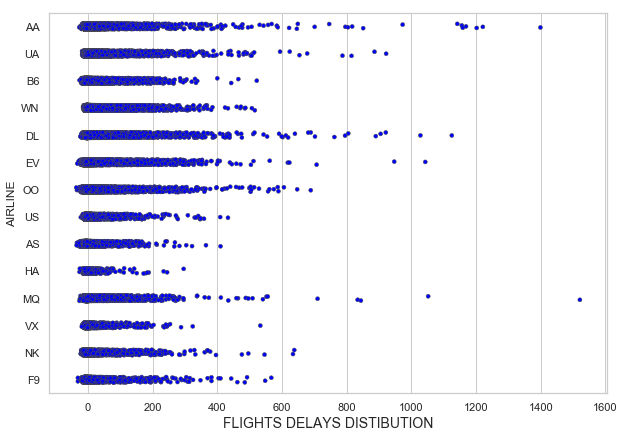

<Figure size 720x504 with 0 Axes>

In [20]:
plt.figure(figsize=(10,7))
ax2=sns.stripplot(y="AIRLINE", x="DEPARTURE_DELAY", size = 4, color = 'blue',
                    data=df_2, linewidth = 0.5,  jitter=True)
plt.xlabel('FLIGHTS DELAYS DISTIBUTION', fontsize=14)
plt.figure(figsize=(10,7))
plt.show()

The graph above shows the distribution of delays among carriers throughout the year. The aim of the analysis is to predict general patterns so outliers related to extraordinary events will be deleted.

In [21]:
#Outliers deletation when 'DEPARTURE_DELAY'>300 . Extreme delays, even though really registered, could bias the estimation of the genral trend.  
boolean =df_2['DEPARTURE_DELAY']>300
index=df_2.index[boolean].tolist()
df_end=df_2.drop(index)

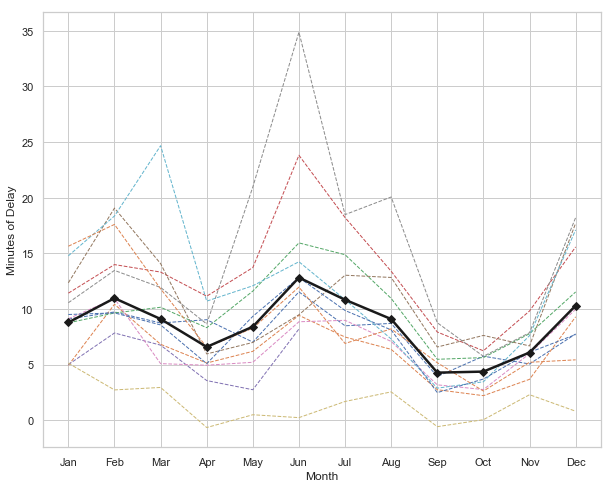

In [22]:
#delay of different companies thoughout the year
# the black line represents the mean among all the carriers 
df_AA=df_end.DEPARTURE_DELAY[df_end['AIRLINE']=='AA'].groupby(df_end['MONTH']).mean()
df_DL=df_end.DEPARTURE_DELAY[df_end['AIRLINE']=='DL'].groupby(df_end['MONTH']).mean()
df_WN=df_end.DEPARTURE_DELAY[df_end['AIRLINE']=='WN'].groupby(df_end['MONTH']).mean()
df_UA=df_end.DEPARTURE_DELAY[df_end['AIRLINE']=='UA'].groupby(df_end['MONTH']).mean()
df_US=df_end.DEPARTURE_DELAY[df_end['AIRLINE']=='US'].groupby(df_end['MONTH']).mean()
df_B6=df_end.DEPARTURE_DELAY[df_end['AIRLINE']=='B6'].groupby(df_end['MONTH']).mean()
df_OO=df_end.DEPARTURE_DELAY[df_end['AIRLINE']=='OO'].groupby(df_end['MONTH']).mean()
df_NK=df_end.DEPARTURE_DELAY[df_end['AIRLINE']=='NK'].groupby(df_end['MONTH']).mean()
df_VX=df_end.DEPARTURE_DELAY[df_end['AIRLINE']=='AS'].groupby(df_end['MONTH']).mean()
df_F9=df_end.DEPARTURE_DELAY[df_end['AIRLINE']=='F9'].groupby(df_end['MONTH']).mean()
df_EV=df_end.DEPARTURE_DELAY[df_end['AIRLINE']=='EV'].groupby(df_end['MONTH']).mean()
df_MQ=df_end.DEPARTURE_DELAY[df_end['AIRLINE']=='MQ'].groupby(df_end['MONTH']).mean()

plt.figure(figsize=(10,8))
plt.plot(df_AA.index,df_AA,'--',df_DL.index,df_DL,'--',df_WN.index,df_WN,'--',df_UA.index,df_UA,'--',df_US.index,df_US,'--',df_B6.index,df_B6,'--',df_OO.index,
         df_OO,'--',df_NK.index,df_NK,'--',df_VX.index,df_VX,'--',df_F9.index,df_F9,'--',df_EV.index,df_EV,'--',df_MQ.index,df_MQ,'--',linewidth=1)
plt.plot(df_end.DEPARTURE_DELAY.groupby(df_end['MONTH']).mean(),'-k',linewidth=2.5,MARKER='D')
plt.ylabel('Minutes of Delay')
plt.xlabel('Month')
plt.xticks(np.arange(1,13), months);



From the graph above it can be noticed that companies share same delay trend with peaks in June February and December. It could be correlated with the number of total flights in those months. The integration of American Airlines and US Airways was completed on April 8, 2015.

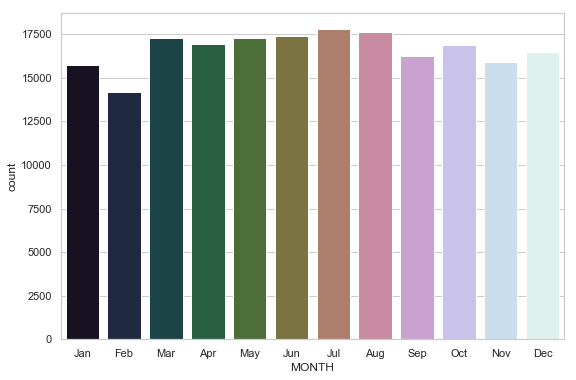

In [23]:
plt.figure(figsize=(9,6))
l=sns.countplot(x="MONTH",palette='cubehelix', data=df_end)
l.set_xticklabels(months);

In December the total number of flights was comparable with other months while in February it was lower than in the other period of the year. Apparently, there is not a strong relation between those two factors.  

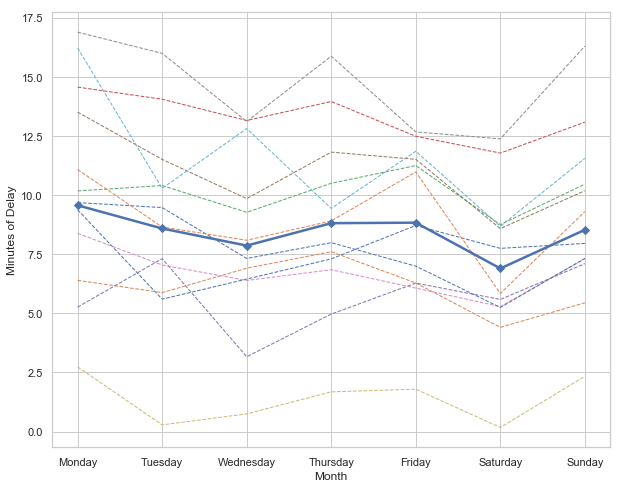

In [24]:
#delay of different companies thoughout the days of the week
#the blu marked line represents the daily mean 
df_AA=df_end.DEPARTURE_DELAY[df_end['AIRLINE']=='AA'].groupby(df_end['DAY_OF_WEEK']).mean()
df_DL=df_end.DEPARTURE_DELAY[df_end['AIRLINE']=='DL'].groupby(df_end['DAY_OF_WEEK']).mean()
df_WN=df_end.DEPARTURE_DELAY[df_end['AIRLINE']=='WN'].groupby(df_end['DAY_OF_WEEK']).mean()
df_UA=df_end.DEPARTURE_DELAY[df_end['AIRLINE']=='UA'].groupby(df_end['DAY_OF_WEEK']).mean()
df_US=df_end.DEPARTURE_DELAY[df_end['AIRLINE']=='US'].groupby(df_end['DAY_OF_WEEK']).mean()
df_B6=df_end.DEPARTURE_DELAY[df_end['AIRLINE']=='B6'].groupby(df_end['DAY_OF_WEEK']).mean()
df_OO=df_end.DEPARTURE_DELAY[df_end['AIRLINE']=='OO'].groupby(df_end['DAY_OF_WEEK']).mean()
df_NK=df_end.DEPARTURE_DELAY[df_end['AIRLINE']=='NK'].groupby(df_end['DAY_OF_WEEK']).mean()
df_VX=df_end.DEPARTURE_DELAY[df_end['AIRLINE']=='AS'].groupby(df_end['DAY_OF_WEEK']).mean()
df_F9=df_end.DEPARTURE_DELAY[df_end['AIRLINE']=='F9'].groupby(df_end['DAY_OF_WEEK']).mean()
df_EV=df_end.DEPARTURE_DELAY[df_end['AIRLINE']=='EV'].groupby(df_end['DAY_OF_WEEK']).mean()
df_MQ=df_end.DEPARTURE_DELAY[df_end['AIRLINE']=='MQ'].groupby(df_end['DAY_OF_WEEK']).mean()

plt.figure(figsize=(10,8))
plt.plot(df_AA.index,df_AA,'--',df_DL.index,df_DL,'--',df_WN.index,df_WN,'--',df_UA.index,df_UA,'--',df_US.index,df_US,'--',df_B6.index,df_B6,'--',df_OO.index,
         df_OO,'--',df_NK.index,df_NK,'--',df_VX.index,df_VX,'--',df_F9.index,df_F9,'--',df_EV.index,df_EV,'--',df_MQ.index,df_MQ,'--',linewidth=1)

plt.plot(df_end.DEPARTURE_DELAY.groupby(df_end['DAY_OF_WEEK']).mean(),'-b',linewidth=2.5,MARKER='D')
plt.ylabel('Minutes of Delay')
plt.xlabel('Month')
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
            'Sunday']
plt.xticks(np.arange(1,8), days);


Regarding week days different carriers present different trends. However, Monday is the day with the highest mean delay and Saturday the one  with the lowest.

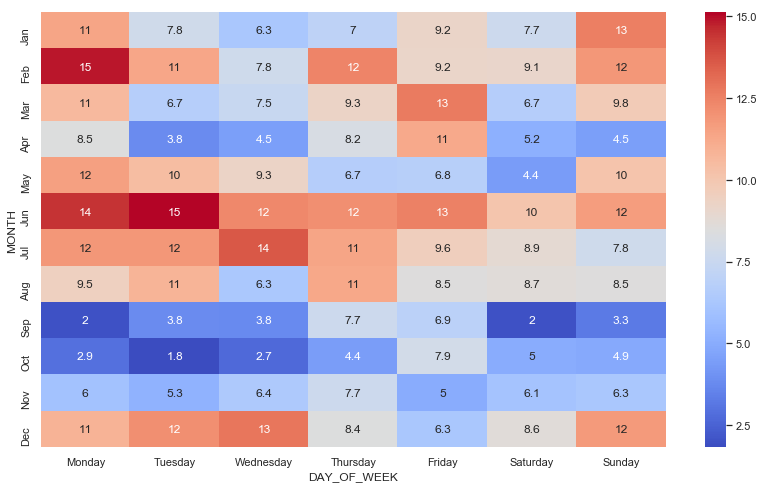

In [25]:
#Comparing delays in differnet month and different days of the week  
pt=df_end.pivot_table(index="MONTH",columns="DAY_OF_WEEK",values="DEPARTURE_DELAY", aggfunc=np.mean)

plt.figure(figsize = (14,8))

ax = sns.heatmap(pt, annot=True,xticklabels=days,yticklabels=months, cmap="coolwarm")


The heatmap above gives an overall trend of flight delays. As seen before, the month of the year of your flight could determinate a higher or lower delay, moreover saturday is the best day and monday the worst. October is the month of the year with the lowest delays.

Although this data is related to 2015 it can be assumed, given the large amount of data(more than 200k) gathered from hundreds of different airports and different companies, that this trend can be generalised.

(-10, 275)

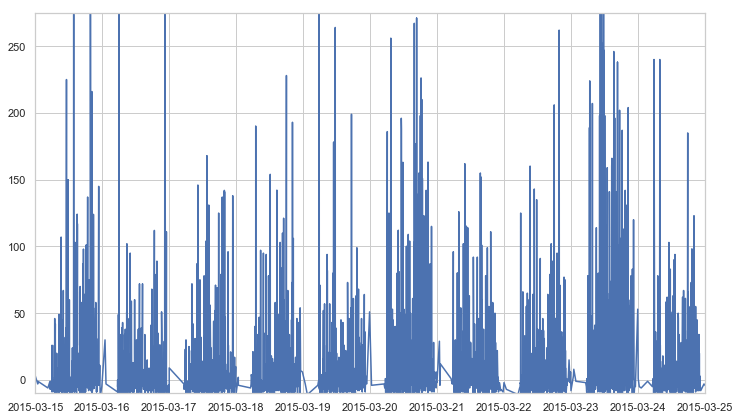

In [26]:
#the delay time  thourhout 10 days

df_end.sort_values('DATE_TIME', inplace = True)


plt.figure(figsize=(12,7))
ax1=plt.plot(df_end['DATE_TIME'], df_end['DEPARTURE_DELAY'], linestyle='-')


date_1 = datetime.datetime(2015,3,15)
date_2 = datetime.datetime(2015,3,25)
axes = plt.gca()
axes.set_xlim([date_1, date_2])
axes.set_ylim([-10, 275])



The graph shows the existence of cycles, both in the frequency of the delays but also in their magnitude. These  cycles represent the day-night alternation and the fact that airports activity is reduced during the night. This suggests that a important variable in the modelling of delays will be take-off time.

Delay time at first morning is  17.81977257820545   while at late night is  36.880602137391385


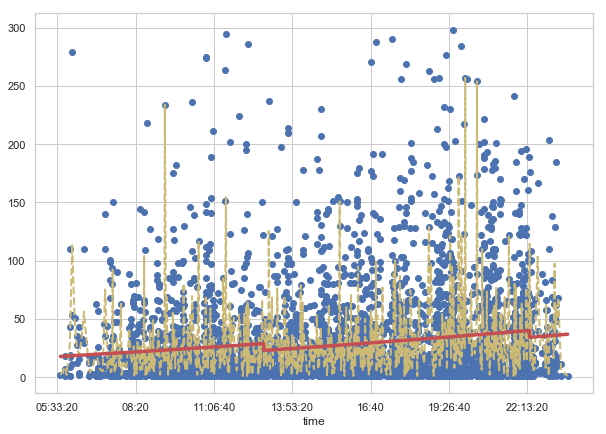

In [27]:
#Different hours of the day at atlanta airport
airport='ATL'
df_ATL = df_end[ (df_end['DEPARTURE_DELAY'] > 0) & (df_end['ORIGIN_AIRPORT'] == airport)]
plt.figure(figsize=(10,7))
plt.plot_date(df_ATL['SCHEDULED_DEPARTURE'], df_ATL['DEPARTURE_DELAY'])

departure_group = df_ATL['DEPARTURE_DELAY'].groupby(df_ATL['SCHEDULED_DEPARTURE']).mean()
plt.plot(departure_group.index, departure_group, '--y', linewidth=2, label='Mean')


conversion = lambda x:x.hour*3600+x.minute*60+x.second   # conversion in seconds used to create x values
x_val = np.array([conversion(s) for s in departure_group.index])
y_val = departure_group
popt, pcov = curve_fit(polynomial, x_val, y_val, p0 = [1, 1, 1])     #non-linear least squares to fit a function to data.
test = pd.Series(polynomial(x_val, *popt), index = departure_group.index)   #y-values, popt are my coefficients
plt.plot(test.index, test, '-r', linewidth=3.5, label='Fit')

print('Delay time at first morning is ', test[0], '  while at late night is ', test[-1])   #delay time is doubled

It can be noticed that the average delay time tends to increase thoroughout the day. 

## 1.3 <a  id='Third-Subsection'> Features Engineering </a>

Two new features have been calculated : TAXI_TOTAL is the total taxi time and DELTA_DELAY is the amount of Delay accumulated after the departure. The aim is to investigate the relation between passengers hand luggage and delay. Ryanair, Irish low cost  carrier, recently point out how passengers hand luggage delayed most of her fligths. Is there any relation beetwen delay and time spent before the flight take off ?

In [28]:
 #new features to check if there is a correlation between 
df_end['TAXI_TOTAL']=df_end['TAXI_IN']+df_end['TAXI_OUT']
df_end['DELTA_DELAY']=df_end['ARRIVAL_DELAY']-df_end['DEPARTURE_DELAY']


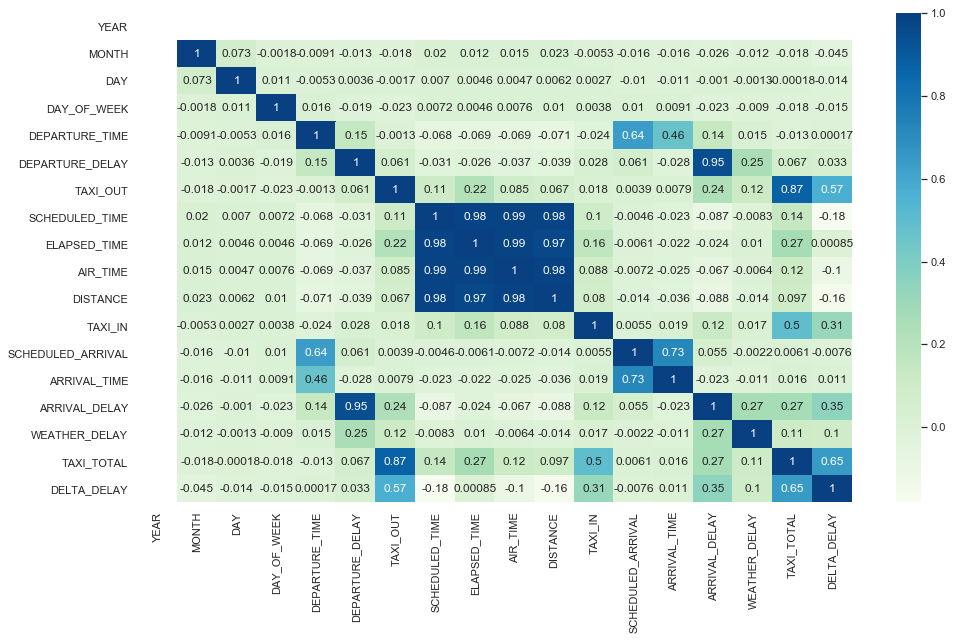

In [29]:
#CORRELATION MATRIX (Pearson Correlation)

corrmat=df_end[df_end['DEPARTURE_DELAY']>0].corr()
plt.figure(figsize = (16,9))
ax = sns.heatmap(corrmat, annot=True, cmap="GnBu")

# Very high correlation among some features

From the correlation matrix we can notice that 4 variables are highly correlated. Distance, air time, elapsed time and scheduled time are highly correlated due to a fix cruise speed used by aircraft to maximise engines efficiency and reduce fuel consumption hence cost(there is not a particular gain in terms of time indeed) . Arrival delay seems to have a slight correlation with the total taxi time, while 'delta delay' and 'taxi total' are highly correlated.

The main reason is that flights Air time is fixed, it depends only on the distance between departure and destination airports.   
However, delta delay could be accumulated during aircrafts set up and mainteinance or to wait other airplanes to take off, not only to customers hand luggage. 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 864x504 with 0 Axes>

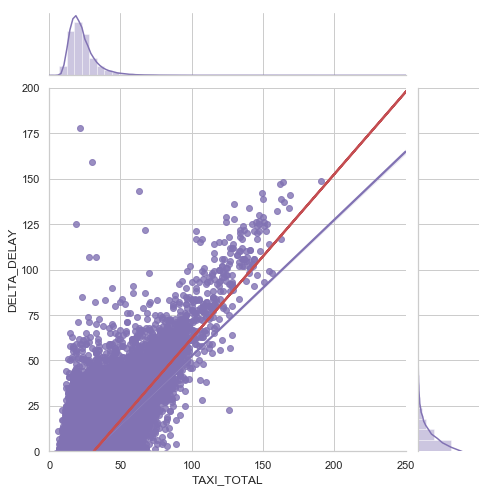

In [30]:
#Strong correlation between delta delay and taxi total.. rayan air?, differently from trains and cars flights delays can not 
#be imputed to traffic jam or other problems during the flight, delays gather before and after it
plt.figure(figsize=(12,7))


h = sns.jointplot("TAXI_TOTAL", "DELTA_DELAY", data=df_end, kind="reg",
                  xlim=(0, 250), ylim=(0, 200), color="m", height=7)

# Trend line(in red) when taxi total is greater than the average
X=df_end.TAXI_TOTAL[df_end['TAXI_TOTAL']>df_end.TAXI_TOTAL.mean()]
Y=df_end.DELTA_DELAY[df_end['TAXI_TOTAL']>df_end.TAXI_TOTAL.mean()]
fit = np.polyfit(X,Y,1)
fit_fn = np.poly1d(fit)
plt.plot(X,fit_fn(X),'-r',linewidth=2.3)


When taxi time is above the mean this correlation become even stronger. This confirms that taxi time plays a key role within the overall arrival delay.  

## 2. <a  id='Second-Section'>  Weather </a>
In this section different weather values and their interaction with flights delay will be considered. Temperature, wind speed, pressure, weather description and humidity will be taken into account for origin airports to evaluate  departure delay. The analysis will be narrowed to three main airports chosen taking into account the amount of flight and the geographical position (west coast, east coast, gulf of Mexico/ Caribbean sea). 

Departure delay will be considered to be correlated with the origin airport weather, without taking in consideration destination airport climate conditions. 

In general, Flights delays can be seen as an origin-destination dataset since airplanes flights above 31,000 ft where weather condition do not influence the flight. The most dangerous condition for aircraft are vertical wind and visibility along the runway, so destination weather condition could influence departure delays as well. 

In [31]:
#Dataset narrowed to Miami, New York and Los Angeles origin airports

df_end.head()
df_end[(df_end['ORIGIN_AIRPORT']=='MIA') |
                        (df_end['ORIGIN_AIRPORT']=='JFK') | (df_end['ORIGIN_AIRPORT']=='LAX') ].shape

(12274, 25)

In [32]:
#features not needed for the analysis
features_to_del = ['TAXI_OUT', 'TAXI_IN', 'YEAR','MONTH','DAY','DAY_OF_WEEK','DATE', 
                                        'AIR_TIME','ELAPSED_TIME','DISTANCE','AIRLINE_names']
df_end1=df_end.drop(features_to_del,axis=1)
df_end1.head()

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_TIME,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,WEATHER_DELAY,DATE_TIME,TAXI_TOTAL,DELTA_DELAY
188311,NK,PBG,FLL,01:55:00,139.0,-16.0,208.0,523,450.0,-33.0,0.0,2015-01-01 01:55:00,17.0,-17.0
157232,UA,BOS,EWR,05:50:00,552.0,2.0,88.0,718,659.0,-19.0,0.0,2015-01-01 05:50:00,21.0,-21.0
202068,B6,SYR,JFK,05:55:00,550.0,-5.0,83.0,718,705.0,-13.0,0.0,2015-01-01 05:55:00,32.0,-8.0
201289,EV,CLT,ORD,06:00:00,559.0,-1.0,123.0,703,721.0,18.0,0.0,2015-01-01 06:00:00,33.0,19.0
121091,WN,SFO,ATL,06:00:00,554.0,-6.0,280.0,1340,1324.0,-16.0,0.0,2015-01-01 06:00:00,17.0,-10.0


In [33]:
#dataset ORIGIN AIRPORT
df_origin=df_end1.merge(df_ports[['IATA_CODE','CITY']],left_on='ORIGIN_AIRPORT', right_on='IATA_CODE')
df_origin.drop(['IATA_CODE','DESTINATION_AIRPORT','DELTA_DELAY'],axis=1,inplace=True)
df_origin.head()

,AIRLINE,ORIGIN_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_TIME,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,WEATHER_DELAY,DATE_TIME,TAXI_TOTAL,CITY
0,NK,PBG,01:55:00,139.0,-16.0,208.0,523,450.0,-33.0,0.0,2015-01-01 01:55:00,17.0,Plattsburgh
1,NK,PBG,01:55:00,204.0,9.0,208.0,523,542.0,19.0,0.0,2015-01-27 01:55:00,37.0,Plattsburgh
2,NK,PBG,01:55:00,139.0,-16.0,208.0,523,514.0,-9.0,0.0,2015-02-09 01:55:00,42.0,Plattsburgh
3,NK,PBG,01:55:00,147.0,-8.0,208.0,523,454.0,-29.0,0.0,2015-02-11 01:55:00,27.0,Plattsburgh
4,NK,PBG,01:55:00,244.0,49.0,203.0,518,557.0,39.0,0.0,2015-03-05 01:55:00,12.0,Plattsburgh


### 2.1<a  id='Fourth-Subsection'> Datasets, data wrangling, and merging </a>
Weather datasets will be read, processed and merged to the main dataset joining them through date and time.

In [34]:
#weather datasets
df_weather=pd.read_csv('historical-hourly-weather-data/weather_description.csv' )
df_temp=pd.read_csv('historical-hourly-weather-data/temperature.csv' )
df_pressure=pd.read_csv('historical-hourly-weather-data/pressure.csv' )
df_humidity=pd.read_csv('historical-hourly-weather-data/humidity.csv' )
df_wind=pd.read_csv('historical-hourly-weather-data/wind_speed.csv' )

In [35]:
# duplicates have been deleted
df_weather.drop_duplicates(inplace=True)   
df_temp.drop_duplicates(inplace=True)   
df_pressure.drop_duplicates(inplace=True)   
df_humidity.drop_duplicates(inplace=True)   
df_wind.drop_duplicates(inplace=True)   

In [36]:
#datetime conversion
df_weather['datetime']=pd.to_datetime(df_weather['datetime'], format= '%Y-%m-%d %H:%M:%S')
df_temp['datetime']=pd.to_datetime(df_temp['datetime'], format= '%Y-%m-%d %H:%M:%S')
df_pressure['datetime']=pd.to_datetime(df_pressure['datetime'], format= '%Y-%m-%d %H:%M:%S')
df_humidity['datetime']=pd.to_datetime(df_humidity['datetime'], format= '%Y-%m-%d %H:%M:%S')
df_wind['datetime']=pd.to_datetime(df_wind['datetime'], format= '%Y-%m-%d %H:%M:%S')


In [37]:
#datasets from 2012 to 2017, I am interested in 2015 values, so I take subdatasets
date_before = pd.Timestamp(2015, 1, 1)
date_after = pd.Timestamp(2016, 1, 1)

df_weather2015=df_weather[(df_weather['datetime']< date_after ) & (df_weather['datetime']> date_before)]
df_temp2015=df_temp[(df_temp['datetime']< date_after ) & (df_temp['datetime']> date_before)]
df_pressure2015=df_pressure[(df_pressure['datetime']< date_after ) & (df_pressure['datetime']> date_before)]
df_humidity2015=df_humidity[(df_humidity['datetime']< date_after ) & (df_humidity['datetime']> date_before)]
df_wind2015=df_wind[(df_wind['datetime']< date_after ) & (df_wind['datetime']> date_before)]

In [38]:
# analysis focused on 3 cities 
cols=['datetime','Miami','New York','Los Angeles']

df_weather3=df_weather2015[cols]
df_temp3=df_temp2015[cols]
df_pressure3=df_pressure2015[cols]
df_humidity3=df_humidity2015[cols]
df_wind3=df_wind2015[cols]

In [39]:
#from untidy to tidy, all cities are merged in a column called 'CITY', and the other column represents the registered value 
#at a given time 'datetime'. 

df_weather3_melt=pd.melt(df_weather3,id_vars=['datetime'],var_name='CITY',value_name='WEATHER_CONDITION')
df_temp3_melt=pd.melt(df_temp3,id_vars=['datetime'],var_name='CITY',value_name='TEMPERATURE') 
df_pressure3_melt=pd.melt(df_pressure3,id_vars=['datetime'],var_name='CITY',value_name='PRESSURE') 
df_humidity3_melt=pd.melt(df_humidity3,id_vars=['datetime'],var_name='CITY',value_name='HUMIDITY') 
df_wind3_melt=pd.melt(df_wind3,id_vars=['datetime'],var_name='CITY',value_name='WIND_SPEED')


In [40]:
#check for missing values
print('Weather dataset information: \n')
df_weather3_melt.info()
print('\nTemperature dataset information: \n')
df_temp3_melt.info()
print('\nPressure dataset information: \n')
df_pressure3_melt.info()
print('\nHumidity dataset information: \n')
df_humidity3_melt.info()
print('\nWind speed dataset information: \n')
df_wind3_melt.info()

print(df_temp3_melt.tail())
df_temp3_melt.head()

Weather dataset information: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26277 entries, 0 to 26276
Data columns (total 3 columns):
datetime             26277 non-null datetime64[ns]
CITY                 26277 non-null object
WEATHER_CONDITION    26277 non-null object
dtypes: datetime64[ns](1), object(2)
memory usage: 615.9+ KB

Temperature dataset information: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26277 entries, 0 to 26276
Data columns (total 3 columns):
datetime       26277 non-null datetime64[ns]
CITY           26277 non-null object
TEMPERATURE    26277 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 615.9+ KB

Pressure dataset information: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26277 entries, 0 to 26276
Data columns (total 3 columns):
datetime    26277 non-null datetime64[ns]
CITY        26277 non-null object
PRESSURE    26277 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 615.9+ KB



,datetime,CITY,TEMPERATURE
0,2015-01-01 01:00:00,Miami,296.401667
1,2015-01-01 02:00:00,Miami,295.678333
2,2015-01-01 03:00:00,Miami,295.535500
3,2015-01-01 04:00:00,Miami,294.618667
4,2015-01-01 05:00:00,Miami,294.282333


Datasets have been uploaded and transformed from wide to long. There are no missing values and dupllicates have been deleted.

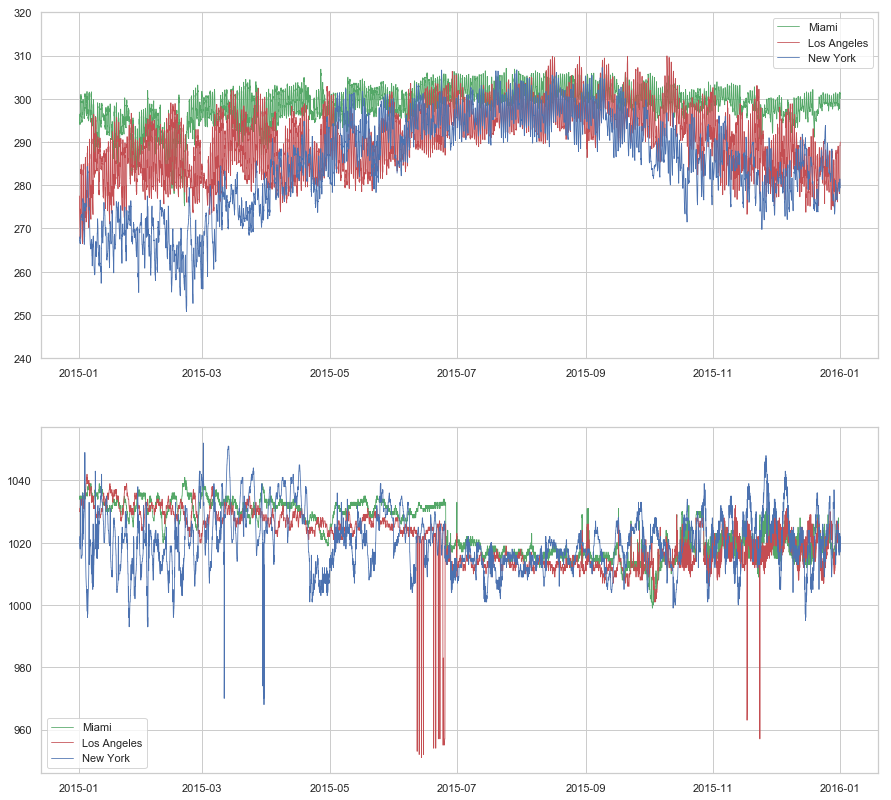

In [41]:
#check for possible outliers

f, (ax1, ax2) = plt.subplots(2,1,figsize=(15,14))
ax1.plot(df_temp3_melt.datetime[df_temp3_melt['CITY']=='Miami'],df_temp3_melt.TEMPERATURE[df_temp3_melt['CITY']=='Miami'],'g-',linewidth=0.8,label='Miami')
ax1.plot(df_temp3_melt.datetime[df_temp3_melt['CITY']=='Los Angeles'],df_temp3_melt.TEMPERATURE[df_temp3_melt['CITY']=='Los Angeles'],'r-',linewidth=0.8,label='Los Angeles')
ax1.plot(df_temp3_melt.datetime[df_temp3_melt['CITY']=='New York'],df_temp3_melt.TEMPERATURE[df_temp3_melt['CITY']=='New York'],'b-',linewidth=0.8,label='New York')
ax1.set_ylim([240, 320])
ax1.legend()

ax2.plot(df_pressure3_melt.datetime[df_pressure3_melt['CITY']=='Miami'],df_pressure3_melt.PRESSURE[df_pressure3_melt['CITY']=='Miami'],'g-',linewidth=0.8,label='Miami')
ax2.plot(df_pressure3_melt.datetime[df_pressure3_melt['CITY']=='Los Angeles'],df_pressure3_melt.PRESSURE[df_pressure3_melt['CITY']=='Los Angeles'],'r-',linewidth=0.8,label='Los Angeles')
ax2.plot(df_pressure3_melt.datetime[df_pressure3_melt['CITY']=='New York'],df_pressure3_melt.PRESSURE[df_pressure3_melt['CITY']=='New York'],'b-',linewidth=0.8,label='New York')
ax2.legend()


Pressure and temperature do not present outliers. Moreover, values of temperature are in line with the correspondent city, New York is colder in the winter time while Miami have a mild weather throughout the year. Temperature follows a seasonal trend as expected.

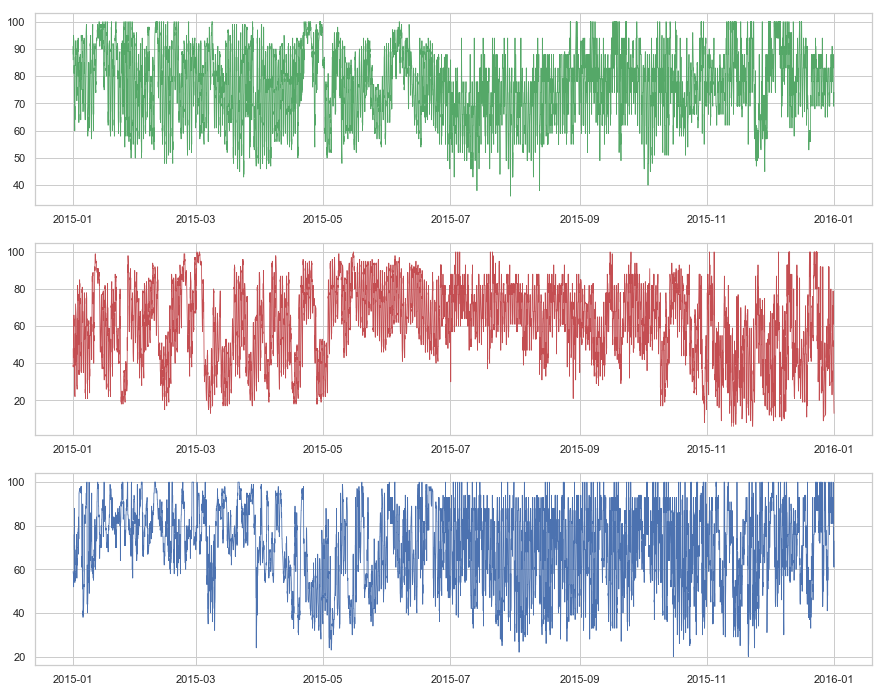

In [42]:
# Annual humidity level in the three cities

f, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(15,12))
ax1.plot(df_humidity3_melt.datetime[df_humidity3_melt['CITY']=='Miami'],df_humidity3_melt.HUMIDITY[df_humidity3_melt['CITY']=='Miami'],'g-',linewidth=0.8)
ax2.plot(df_humidity3_melt.datetime[df_humidity3_melt['CITY']=='Los Angeles'],df_humidity3_melt.HUMIDITY[df_humidity3_melt['CITY']=='Los Angeles'],'r-',linewidth=0.8)
ax3.plot(df_humidity3_melt.datetime[df_humidity3_melt['CITY']=='New York'],df_humidity3_melt.HUMIDITY[df_humidity3_melt['CITY']=='New York'],'b-',linewidth=0.8)


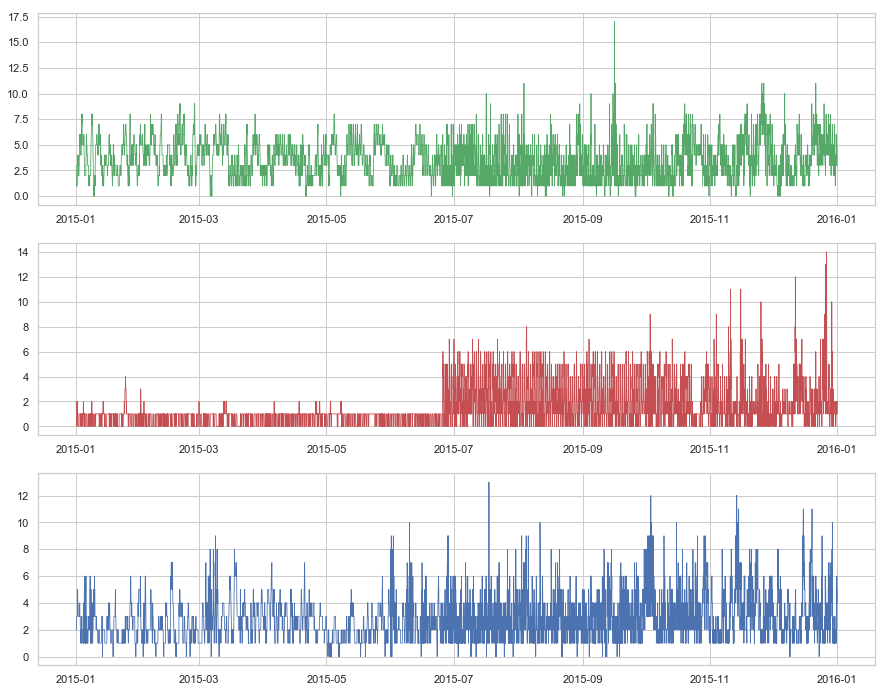

In [43]:
# Annual wind speed
f, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(15,12))
ax1.plot(df_wind3_melt.datetime[df_wind3_melt['CITY']=='Miami'],df_wind3_melt.WIND_SPEED[df_wind3_melt['CITY']=='Miami'],'g-',linewidth=0.8)
ax2.plot(df_wind3_melt.datetime[df_wind3_melt['CITY']=='Los Angeles'],df_wind3_melt.WIND_SPEED[df_wind3_melt['CITY']=='Los Angeles'],'r-',linewidth=0.8)
ax3.plot(df_wind3_melt.datetime[df_wind3_melt['CITY']=='New York'],df_wind3_melt.WIND_SPEED[df_wind3_melt['CITY']=='New York'],'b-',linewidth=0.8)




No missing values or outliers present. Wind speed >= 0 and range of pressure and wind speed reasonable.


In [44]:
#final dataset  which will be merged with df_origin3
df_weather_end=pd.concat([df_weather3_melt['datetime'],df_weather3_melt['CITY'],df_weather3_melt['WEATHER_CONDITION'],
                         df_temp3_melt['TEMPERATURE'],df_pressure3_melt['PRESSURE'],df_humidity3_melt['HUMIDITY'],df_wind3_melt['WIND_SPEED']],axis=1)

In [45]:
#subdataset with three selected cities
df_origin3=df_origin[ (df_origin['ORIGIN_AIRPORT']=='MIA') |
                        (df_origin['ORIGIN_AIRPORT']=='JFK') | (df_origin['ORIGIN_AIRPORT']=='LAX') ]


In [46]:
#lists used to collect selected values
list_weather=[]
list_temp=[]
list_pressure=[]
list_humidity=[]
list_wind=[]


The code below has been used to compare df_origin3 and  df_weather_end in order to assign the right weather conditions to each flight. Every inner loop takes 4-6 seconds, so given the amount of instances this code run for 12h or more. A copy has been saved at the end to make it available without running it again.   

I want to get weather conditions if City, date and hour of datasets are the same. I compare 'CITY' of the two datasets and time and hour of 'datetime' and 'DATETIME' (using strings that do not take minutes cause I have climate conditions at 2.00pm, 3.00pm and on..) 

In [47]:

'''
for i,s in enumerate(df_origin3['DATE_TIME']) :
    str1=s.strftime('%Y-%m-%d %H')     # date and time will be compared as strings
    t = time.time() # used to track computational time of each inner loop  
    
    for j,s2 in enumerate(df_weather_end['datetime']) :
        
        str2=s2.strftime('%Y-%m-%d %H')  # need a string 
        

        if (np.logical_and((str1[:13]==str2[:13]) , (df_origin3.iloc[i]['CITY']==df_weather_end.iloc[j]['CITY'] ))) : # same date and same hour and same city
              print('i am doing something')  # track if the condition is satisfied, so I am sure a value will be registered
              list_weather.append(df_weather_end.iloc[j]['WEATHER_CONDITION'])
              list_temp.append(df_weather_end.iloc[j]['TEMPERATURE'])
              list_pressure.append(df_weather_end.iloc[j]['PRESSURE'])
              list_humidity.append(df_weather_end.iloc[j]['HUMIDITY'])
              list_wind.append(df_weather_end.iloc[j]['WIND_SPEED'])
              break                                                       # being a time consuming double loop, 
                                                                          #the inner loop stops when the condition is met and values are saved, 
                                                                          #I don't have to go through all the dataframe 
         
    print (i,'  ',time.time()-t )  # used to know the current external iteration and inner loop time

# lists merged to the dataframe
df_origin3['WEATHER_CONDITION']=list_weather
df_origin3['TEMPERATURE']=list_temp
df_origin3['PRESSURE']=list_pressure
df_origin3['HUMIDITY']=list_humidity
df_origin3['WIND_SPEED'] = list_wind


df_origin3.to_csv('df_origin3.csv')

'''


"\nfor i,s in enumerate(df_origin3['DATE_TIME']) :\n    str1=s.strftime('%Y-%m-%d %H')     # date and time will be compared as strings\n    t = time.time() # used to track computational time of each inner loop  \n    \n    for j,s2 in enumerate(df_weather_end['datetime']) :\n        \n        str2=s2.strftime('%Y-%m-%d %H')  # need a string \n        \n\n        if (np.logical_and((str1[:13]==str2[:13]) , (df_origin3.iloc[i]['CITY']==df_weather_end.iloc[j]['CITY'] ))) : # same date and same hour and same city\n              print('i am doing something')  # track if the condition is satisfied, so I am sure a value will be registered\n              list_weather.append(df_weather_end.iloc[j]['WEATHER_CONDITION'])\n              list_temp.append(df_weather_end.iloc[j]['TEMPERATURE'])\n              list_pressure.append(df_weather_end.iloc[j]['PRESSURE'])\n              list_humidity.append(df_weather_end.iloc[j]['HUMIDITY'])\n              list_wind.append(df_weather_end.iloc[j]['WIND_SPEE

In [48]:
#read saved dataset
df_origin3=pd.read_csv('df_origin3.csv')

### 2.2<a  id='Fifth-Subsection'> Exploratory Data Analysis </a>

In [49]:
df_origin3.info()

df_origin3.rename({"Unnamed: 0":"a"}, axis=1, inplace=True)
df_origin3.rename({"Unnamed: 0.1":"b"}, axis=1, inplace=True)
df_origin3.drop(['a','b'],axis=1,inplace=True)

df_origin3.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 20 columns):
Unnamed: 0             10716 non-null int64
Unnamed: 0.1           10716 non-null int64
AIRLINE                10716 non-null object
ORIGIN_AIRPORT         10716 non-null object
SCHEDULED_DEPARTURE    10716 non-null object
DEPARTURE_TIME         10716 non-null float64
DEPARTURE_DELAY        10716 non-null float64
SCHEDULED_TIME         10716 non-null float64
SCHEDULED_ARRIVAL      10716 non-null int64
ARRIVAL_TIME           10716 non-null float64
ARRIVAL_DELAY          10716 non-null float64
WEATHER_DELAY          10716 non-null float64
DATE_TIME              10716 non-null object
TAXI_TOTAL             10716 non-null float64
CITY                   10716 non-null object
WEATHER_CONDITION      10716 non-null object
TEMPERATURE            10716 non-null float64
PRESSURE               10716 non-null float64
HUMIDITY               10716 non-null float64
WIND_SPEED             10716 

,AIRLINE,ORIGIN_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_TIME,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,WEATHER_DELAY,DATE_TIME,TAXI_TOTAL,CITY,WEATHER_CONDITION,TEMPERATURE,PRESSURE,HUMIDITY,WIND_SPEED
0,AA,LAX,06:50:00,644.0,-6.0,80.0,810,803.0,-7.0,0.0,2015-01-01 06:50:00,24.0,Los Angeles,sky is clear,271.340000,1031.0,52.0,1.0
1,UA,LAX,08:40:00,834.0,-6.0,296.0,1636,1603.0,-33.0,0.0,2015-01-01 08:40:00,19.0,Los Angeles,sky is clear,268.373667,1031.0,64.0,0.0
2,WN,LAX,11:10:00,1110.0,0.0,230.0,1700,1655.0,-5.0,0.0,2015-01-01 11:10:00,15.0,Los Angeles,sky is clear,267.769667,1031.0,65.0,1.0
3,OO,LAX,11:30:00,1139.0,9.0,88.0,1358,1352.0,-6.0,0.0,2015-01-01 11:30:00,17.0,Los Angeles,sky is clear,267.769667,1031.0,65.0,1.0
4,VX,LAX,13:25:00,1325.0,0.0,285.0,2110,2100.0,-10.0,0.0,2015-01-01 13:25:00,10.0,Los Angeles,sky is clear,268.462667,1032.0,57.0,2.0


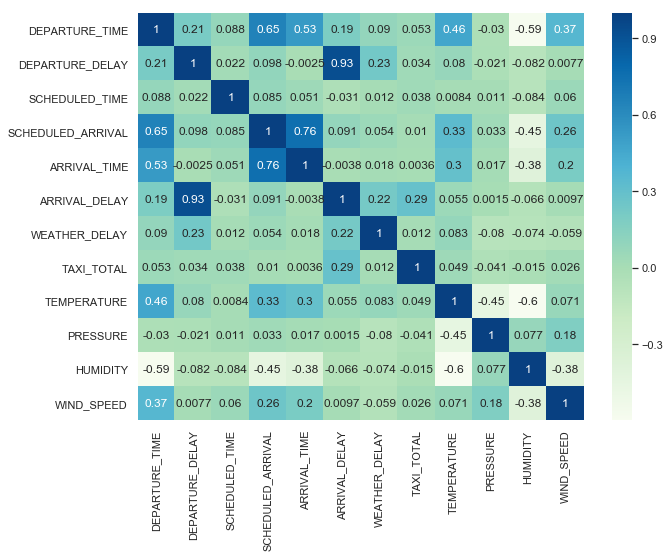

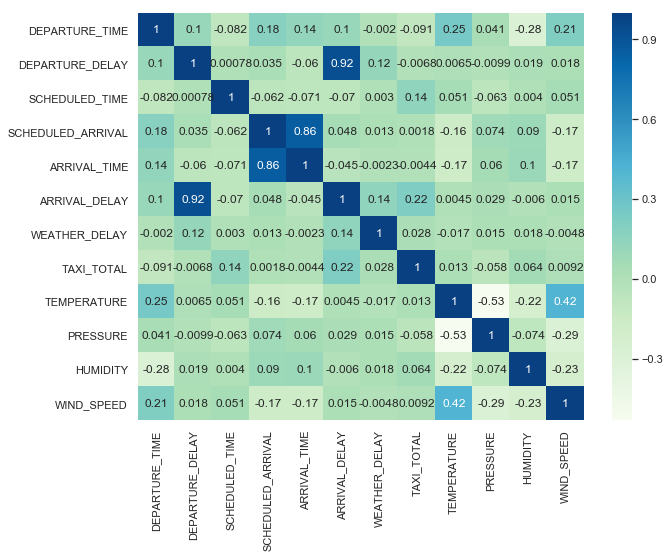

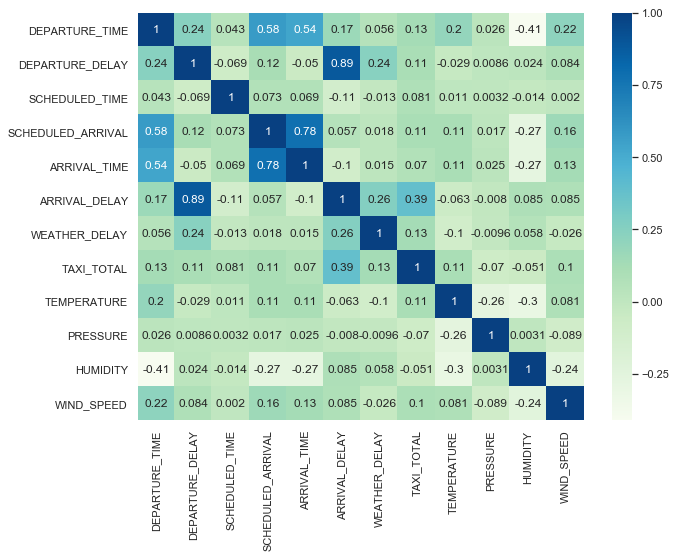

In [50]:
#CORRELATION MATRIX of  (Pearson Correlation)
corrmatweather=df_origin3[(df_origin3['CITY']=='Miami')].corr()
plt.figure(figsize = (10,7.5))
ax = sns.heatmap(corrmatweather, annot=True, cmap="GnBu")

corrmatweather2=df_origin3[(df_origin3['CITY']=='Los Angeles')].corr()
plt.figure(figsize = (10,7.5))
ax = sns.heatmap(corrmatweather2, annot=True, cmap="GnBu")

corrmatweather3=df_origin3[(df_origin3['CITY']=='New York')].corr()
plt.figure(figsize = (10,7.5))
ax = sns.heatmap(corrmatweather3, annot=True, cmap="GnBu")

Single measurements seem to have low correlation with flights delays. Among them the most correlated is Humidity, which is influenced by precipitation. Some variables have high correlation which could lead to multicollinearity. 

In [51]:
# weather conditions will be grouped in 3 clusters:  hostile , mild , cloudy. 
df_conditions=df_origin3['DEPARTURE_DELAY'].groupby(df_origin3['WEATHER_CONDITION']).mean()
print(df_conditions)


WEATHER_CONDITION
broken clouds                     9.382504
drizzle                           6.250000
dust                             18.000000
few clouds                        9.955245
fog                              10.471264
haze                             13.753165
heavy intensity drizzle           7.000000
heavy intensity rain             26.594595
light intensity drizzle          11.611111
light rain                       15.156455
light snow                       32.400000
mist                             11.891667
moderate rain                    17.135542
overcast clouds                  16.084507
proximity shower rain            10.055556
proximity thunderstorm           21.875000
scattered clouds                 11.259048
sky is clear                      8.879793
smoke                             0.800000
snow                             25.764706
thunderstorm                     26.216667
thunderstorm with heavy rain      3.000000
thunderstorm with light rain     22.

In [52]:
#3 different clusters, hostile , mild , cloudy 
mild =['smoke','sky is clear','scattered clouds','few clouds']

cloudy=['overcast clouds','proximity shower rain','mist','light intensity drizzle','haze','dust','drizzle','broken clouds','fog']

hostile=['very heavy rain','thunderstorm with rain','thunderstorm with light rain','thunderstorm with heavy rain','thunderstorm',
        'snow','light rain','proximity thunderstorm','moderate rain','light snow','heavy intensity drizzle','heavy intensity rain']

df_origin3B=df_origin3.copy()

df_origin3B['WEATHER_CONDITION'].replace(mild,'mild',inplace=True)
df_origin3B['WEATHER_CONDITION'].replace(cloudy,'cloudy',inplace=True)
df_origin3B['WEATHER_CONDITION'].replace(hostile,'hostile',inplace=True)

In [53]:
#Delay time for different weather conditions
df_origin3B['DEPARTURE_DELAY'].groupby(df_origin3B['WEATHER_CONDITION']).mean()


WEATHER_CONDITION
cloudy     11.825963
hostile    17.418000
mild        9.383032
Name: DEPARTURE_DELAY, dtype: float64

In [54]:
#Delay time for different weather conditions in different cities
df_origin3B[['DEPARTURE_DELAY','CITY','WEATHER_CONDITION']].groupby(['CITY','WEATHER_CONDITION']).mean()

DEPARTURE_DELAY
CITY        WEATHER_CONDITION                 
Los Angeles cloudy                   11.614145
            hostile                  15.422509
            mild                      9.076639
Miami       cloudy                   14.594059
            hostile                  17.154580
            mild                     11.136444
New York    cloudy                   10.070408
            hostile                  20.228111
            mild                      8.768473

In [55]:
#Delay time for different weather conditions of different airlines
df_origin3B[['DEPARTURE_DELAY','AIRLINE','WEATHER_CONDITION']].groupby(['AIRLINE','WEATHER_CONDITION']).mean()

DEPARTURE_DELAY
AIRLINE WEATHER_CONDITION                 
AA      cloudy                   10.651139
        hostile                  15.986325
        mild                      7.806418
AS      cloudy                   -0.300000
        hostile                   7.130435
        mild                      0.351648
B6      cloudy                   14.217241
        hostile                  22.273381
        mild                     11.670146
DL      cloudy                   11.357737
        hostile                  16.171642
        mild                     10.223092
F9      cloudy                   22.057143
        hostile                  11.238095
        mild                     11.323810
MQ      cloudy                    1.500000
        hostile                   0.000000
        mild                      4.272727
NK      cloudy                   30.594595
        hostile                  25.071429
        mild                     16.238462
OO      cloudy                    7.971963
        hostile                  19.031250
        mild                      8.309524
UA      cloudy                   11.647260
        hostile                  16.487342
        mild                     10.480465
US      cloudy                    7.813953
        hostile                  21.543860
        mild                      5.069767
VX      cloudy                   15.057895
        hostile                  12.552632
        mild                      9.967949
WN      cloudy                   13.759358
        hostile                  28.450549
        mild                     12.017857

Grouping weather conditions, we can see the mean effect of weather on flights delay. Hostle weather increses delays from 5 to 10 minutes. 

## 3.<a  id='Third-Section'>Machine Learning </a>

### 3.1 <a  id='Sixth-Subsection'>Prediction </a>

Flights delays of MAY will be predicted using data from January until April, two different methods (multilinear regression and random forest)  will be used taking into account weather variables to see the added value of using them. 

In [56]:
#Categorical variables transformed using One hot Encoding, excessive delays removed

#WEATHER
dummies = pd.get_dummies(df_origin3B['WEATHER_CONDITION'])

df_regression = pd.concat([df_origin3B, dummies], axis=1)      

df_regression.drop(['ARRIVAL_DELAY','WEATHER_CONDITION','CITY','AIRLINE','ORIGIN_AIRPORT','WEATHER_DELAY','ARRIVAL_TIME','TAXI_TOTAL','DEPARTURE_TIME'], inplace=True, axis=1)

# Delay of 120 minutes or more deleted
df_regression2=df_regression[(df_regression['DEPARTURE_DELAY'] >0) & (df_regression['DEPARTURE_DELAY']<120)]

#CITY
dummies2 = pd.get_dummies(df_origin3B['CITY'])

df_regression2 = pd.concat([df_regression, dummies2], axis=1)  

df_regression3=df_regression2.copy()


#Variables date and hour will be used to predict mean delay of different days and different hours of a day

#Month of the year
df_regression3['DATE_TIME']=pd.to_datetime(df_regression3['DATE_TIME'], format= '%Y-%m-%d %H:%M:%S')
df_regression3['MONTH']=[ x.month for x in df_regression3['DATE_TIME']]
df_regression3['DATE']=[ x.strftime('%Y-%m-%d') for x in df_regression3['DATE_TIME']]
df_regression3['HOUR']=[ x.hour for x in df_regression3['DATE_TIME']]

#to date_time
df_regression3['SCHEDULED_DEPARTURE']=pd.to_datetime(df_regression3['SCHEDULED_DEPARTURE'], format= '%H:%M:%S') #to date_time
conversion = lambda x:x.hour*3600+x.minute*60+x.second 
df_regression3['SCHEDULED_DEPARTURE']= np.array([conversion(s) for s in df_regression3['SCHEDULED_DEPARTURE']]) #conversion to seconds


df_regressionDATE=df_regression3.groupby(df_regression3['DATE']).mean()



df_regressionDATE.drop(['HOUR'], inplace=True, axis=1)
print(df_regressionDATE.head())


            SCHEDULED_DEPARTURE  DEPARTURE_DELAY  SCHEDULED_TIME  \
DATE                                                               
2015-01-01         55374.285714         1.000000      191.333333   
2015-01-02         51332.307692        13.487179      212.666667   
2015-01-03         55924.800000        30.600000      197.120000   
2015-01-04         51735.000000        22.312500      197.812500   
2015-01-05         47110.909091         8.424242      201.060606   

            SCHEDULED_ARRIVAL  TEMPERATURE     PRESSURE   HUMIDITY  \
DATE                                                                 
2015-01-01        1559.952381   281.452341  1032.095238  53.523810   
2015-01-02        1597.948718   281.422383  1031.846154  64.615385   
2015-01-03        1423.600000   281.186747  1034.120000  68.000000   
2015-01-04        1404.437500   282.138797  1035.562500  65.593750   
2015-01-05        1581.393939   277.958609  1034.606061  73.696970   

            WIND_SPEED    cloudy

--------------------------------------------------------------------------------------------------------------------------------


Prediction PART 1 : 

Prediction of May delays using the mean daily values. Flights delay have been grouped by date and will be subsequently used to predict mean delays in May 

In [57]:
#I want to delete any possible extreme values which could affect the prediction. this is amplified by the number of observations in our dataset, where the impact of extreme 
#delays is magnified by the limited number of flights. Presumably, the impact of such delays would be less pronounced using the whole dataset 

#train and test prediction of peak DELAYS

df_train=df_regressionDATE[(df_regressionDATE['MONTH']< 5)]
df_test=df_regressionDATE[(df_regressionDATE['MONTH']==5)]

X_train = df_train.drop(['DEPARTURE_DELAY'],axis=1)
X_test =df_test.drop(['DEPARTURE_DELAY'],axis=1)
y_train =df_train['DEPARTURE_DELAY']
y_test =df_test['DEPARTURE_DELAY']

y_test.shape

(31,)

In [58]:
#REGRESSION COEFFICIENTS to Identify Important Variables

r2=[]

for x in X_train :
        linear=sm.OLS(y_train, X_train[x]).fit()
        r2.append(linear.rsquared)
print(np.round(r2,4))
print(X_train.columns.values)

[0.6015 0.6032 0.596  0.5927 0.595  0.608  0.5401 0.2553 0.3679 0.4749
 0.56   0.4955 0.597  0.5085]
['SCHEDULED_DEPARTURE' 'SCHEDULED_TIME' 'SCHEDULED_ARRIVAL' 'TEMPERATURE'
 'PRESSURE' 'HUMIDITY' 'WIND_SPEED' 'cloudy' 'hostile' 'mild'
 'Los Angeles' 'Miami' 'New York' 'MONTH']


The first six vaiables have a higher R2

In [59]:
#The variance inflation factor (VIF) has been now used to identify collinearity among continuous features and drop those features which are correlated 

X_train=calculate_vif_(X_train[['SCHEDULED_DEPARTURE', 'SCHEDULED_TIME', 'SCHEDULED_ARRIVAL', 'TEMPERATURE',
 'PRESSURE', 'HUMIDITY', 'WIND_SPEED']])

dropping 'PRESSURE' at index: 4
dropping 'TEMPERATURE' at index: 3
dropping 'SCHEDULED_DEPARTURE' at index: 0
dropping 'SCHEDULED_ARRIVAL' at index: 1
Remaining variables:
Index(['SCHEDULED_TIME', 'HUMIDITY', 'WIND_SPEED'], dtype='object')


The remains variable will be used to predict delay with two different models: multilinear regression and random forest regressor.

In [60]:
#multilinear regression with selected variables : Day
sm.OLS(y_train, X_train).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        DEPARTURE_DELAY   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     61.82
Date:                Sat, 15 Dec 2018   Prob (F-statistic):           5.07e-24
Time:                        22:08:48   Log-Likelihood:                -441.67
No. Observations:                 120   AIC:                             889.3
Df Residuals:                     117   BIC:                             897.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
SCHEDULED_TIME     0.0316      0.025      1.253      0.213      -0.018       0.081
HUMIDITY           0.1043      0.065      1.604      0.111      -0.024       0.233
WIND_SPEED        -1.0770      1.651     -0.652      0.516      -4.347       2.193
==============================================================================
Omnibus:                       36.370   Durbin-Watson:                   1.731
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.540
Skew:                           1.365   Prob(JB):                     1.59e-14
Kurtosis:                       5.292   Cond. No.                         424.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
#Test results
linear_selected=sm.OLS(y_train, X_train).fit()

results=linear_selected.predict(X_test[['SCHEDULED_TIME', 'HUMIDITY', 'WIND_SPEED']])
print('r2_score : ',r2_score(y_test,results))
print ('MSE : ',MSE(y_test,results))
print('MAE : ',MAE(y_test,results))

r2_score :  -0.11971617799657763
MSE :  102.42984753841831
MAE :  8.381927124955746


In [62]:
#DAY DELAY USING RANDOM FOREST Regressor
regressor= RandomForestRegressor(n_estimators = 100, random_state = 0)

regressor.fit(X_train,y_train)

results=regressor.predict(X_test[['SCHEDULED_TIME', 'HUMIDITY', 'WIND_SPEED']])

print (sorted(zip(map(lambda x: round(x, 4), regressor.feature_importances_), X_train.columns), 
             reverse=True))

print('r2_score : ',r2_score(y_test,results))
print ('MSE : ',MSE(y_test,results))
print('MAE : ',MAE(y_test,results))

[(0.3978, 'HUMIDITY'), (0.3636, 'SCHEDULED_TIME'), (0.2386, 'WIND_SPEED')]
r2_score :  -0.6976125857220732
MSE :  155.29488789376367
MAE :  9.429240487678788


Both mean squared error (MSE) and mean absolute error (MAE) are used in predictive modelling. Because of the square, large errors have relatively greater influence on MSE than do the smaller error. Therefore, MAE is more robust to outliers since it does not make use of square. R2 score gives the general accuracy of the model.

Using variables which have not a good correlation with the dependent variable lead to poor results. This is mostly due to the combination of multiple factors involved in Flights Delays and more in general transports delays prediction.  

--------------------------------------------------------------------------------------------------------------------------------




Prediction PART 2 : 

Prediction of Flights delay through the day, in this case flights have been grouped by departure time (hour).

In [63]:
# DELAY OVER THE DAY TIME, a new dataset have been created 

df_train=df_regression3[(df_regression3['MONTH']< 5)]
df_test=df_regression3[(df_regression3['MONTH']==5)]

df_train_HOUR=df_train.groupby(df_train['HOUR']).mean()
df_test_HOUR=df_test.groupby(df_test['HOUR']).mean()

X_train = df_train_HOUR.drop(['DEPARTURE_DELAY'],axis=1)
X_test =df_test_HOUR.drop(['DEPARTURE_DELAY'],axis=1)
y_train =df_train_HOUR['DEPARTURE_DELAY']
y_test =df_test_HOUR['DEPARTURE_DELAY']



In [64]:
# Variance inflation factor (VIF) 

X_trainVIF=calculate_vif_(X_train[['SCHEDULED_DEPARTURE', 'SCHEDULED_TIME', 'SCHEDULED_ARRIVAL', 'TEMPERATURE',
 'PRESSURE', 'HUMIDITY', 'WIND_SPEED']])

dropping 'PRESSURE' at index: 4
dropping 'TEMPERATURE' at index: 3
Remaining variables:
Index(['SCHEDULED_DEPARTURE', 'SCHEDULED_TIME', 'SCHEDULED_ARRIVAL',
       'HUMIDITY', 'WIND_SPEED'],
      dtype='object')


In [65]:
#Multilinear regression Summary using selected features
sm.OLS(y_train, X_trainVIF).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        DEPARTURE_DELAY   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     62.81
Date:                Sat, 15 Dec 2018   Prob (F-statistic):           6.03e-10
Time:                        22:08:48   Log-Likelihood:                -51.426
No. Observations:                  21   AIC:                             112.9
Df Residuals:                      16   BIC:                             118.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
SCHEDULED_DEPARTURE  8.949e-05   4.18e-05      2.139      0.048    7.98e-07       0.000
SCHEDULED_TIME          0.0094      0.015      0.631      0.537      -0.022       0.041
SCHEDULED_ARRIVAL       0.0096      0.003      3.193      0.006       0.003       0.016
HUMIDITY               -0.0906      0.061     -1.494      0.155      -0.219       0.038
WIND_SPEED             -1.5969      1.943     -0.822      0.423      -5.716       2.522
==============================================================================
Omnibus:                        1.959   Durbin-Watson:                   1.669
Prob(Omnibus):                  0.375   Jarque-Bera (JB):                1.045
Skew:                          -0.083   Prob(JB):                        0.593
Kurtosis:                       1.920   Cond. No.                     1.47e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.47e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Even if Variance inflation factor deleted some variables, high values of P>|t| and high codition number can be noticed. To further investigate features and correlation a process of features permutation gives use the summary of a model applied to different datasets. Doing so I will figure out which features are not correlated and will keep them. 

In [66]:
# Features permutation to check whether or not one of them improves the model

features=['TEMPERATURE','SCHEDULED_TIME','PRESSURE', 'HUMIDITY', 'WIND_SPEED']

featureslist=[]
for col in features :
    print(sm.OLS(y_train, X_train[['SCHEDULED_DEPARTURE','SCHEDULED_ARRIVAL',col]]).fit().summary())

 

                            OLS Regression Results                            
Dep. Variable:        DEPARTURE_DELAY   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     96.46
Date:                Sat, 15 Dec 2018   Prob (F-statistic):           2.78e-11
Time:                        22:08:48   Log-Likelihood:                -53.410
No. Observations:                  21   AIC:                             112.8
Df Residuals:                      18   BIC:                             116.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
SCHEDULED_DEPARTURE     0.0001   3

Among all the features HUMIDITY has lower P>|t|, so it will be used to predict Flights delay. 

In [67]:
#Multilinear regression Test using Selected features
linear_selected=sm.OLS(y_train, X_train[['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL',
       'HUMIDITY']]).fit()

results=linear_selected.predict(X_test[['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL',
       'HUMIDITY']])
print('r2_score is : ',r2_score(y_test,results))
print ('MSE : ',MSE(y_test,results))
print('MAE is : ',MAE(y_test,results))

r2_score is :  0.4330460503317186
MSE :  25.33364210014471
MAE is :  4.19650405876333


In [68]:
#RF REGRESSOR using selected features
regressor1 = RandomForestRegressor(n_estimators = 100, random_state = 0)
regressor1.fit(X_train[['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL',
       'HUMIDITY']],y_train)

results=regressor1.predict(X_train[['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL',
       'HUMIDITY']])

print (sorted(zip(map(lambda x: round(x, 4), regressor1.feature_importances_), X_train.columns), 
             reverse=True))

print('\nResults on training set:')
print('\nr2_score : ',r2_score(y_train,results))
print ('MSE : ',MSE(y_train,results))
print('MAE is : ',MAE(y_train,results))


results2=regressor1.predict(X_test[['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL',
       'HUMIDITY']])

print('\nResults on test set:')
print('\nr2_score : ',r2_score(y_test,results2))
print ('MSE : ',MSE(y_test,results2))
print('MAE is : ',MAE(y_test,results2))

[(0.4679, 'SCHEDULED_TIME'), (0.4052, 'SCHEDULED_DEPARTURE'), (0.127, 'SCHEDULED_ARRIVAL')]

Results on training set:

r2_score :  0.9330555646697427
MSE :  1.9050975430460049
MAE is :  1.1851679104804216

Results on test set:

r2_score :  0.3840175337298839
MSE :  27.52442125075933
MAE is :  4.401492050985274


In [69]:
#Grid search used to find the best model and use it to estimate flight delays 

RFregressor = RandomForestRegressor()

grid = {'bootstrap': [True],
              'max_depth' :[4, 6, 8,10,12],
                'max_features':[1,2,3],
              'n_estimators': [25,50,75,100,125]
       }
    
model_gridtot=GridSearchCV(estimator=RFregressor,param_grid =grid,cv=3,n_jobs=-1,verbose=2)
    
model_gridtot.fit(X_train[['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL',
       'HUMIDITY']],y_train)

print(model_gridtot.best_params_)

Fitting 3 folds for each of 75 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.5s


{'bootstrap': True, 'max_depth': 10, 'max_features': 2, 'n_estimators': 25}


[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:   14.9s finished


In [70]:
#here i use the best estimator TRAIN

modeltot=model_gridtot.best_estimator_

results= modeltot.predict(X_train[['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL',
       'HUMIDITY']])


print('\nResults on training set:')
print('\nr2_score : ',r2_score(y_train,results))
print ('MSE : ',MSE(y_test,results))
print('MAE is : ',MAE(y_test,results))


Results on training set:

r2_score :  0.9377362927509567
MSE :  26.285449637152823
MAE is :  4.116483977531544


In [71]:
#here i use the best estimator TEST
results2= modeltot.predict(X_test[['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL',
       'HUMIDITY']])

print('\nResults on test set:')
print('\nr2_score : ',r2_score(y_test,results2))
print ('MSE : ',MSE(y_test,results2))
print('MAE is : ',MAE(y_test,results2))



Results on test set:

r2_score :  0.4151941330796982
MSE :  26.131333134361324
MAE is :  4.25348527445189


Thanks to VIF and feature selection collinearity problems which led to overfitting and bad results have been deleted. Doing so multilinear regression gave better results than before, while RF gave the best results using VIF selected features (r2 =0.432, tested using X_trainVIF and X_test [['SCHEDULED_DEPARTURE', 'SCHEDULED_TIME', 'SCHEDULED_ARRIVAL', 'TEMPERATURE',
 'PRESSURE', 'HUMIDITY', 'WIND_SPEED']]). 
 
In the last step humidity will be kept out to see the difference in terms of prediction accuracy when  weather features are not used.  

In [72]:
#Test results
linear_selected=sm.OLS(y_train, X_train[['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL' ]]).fit()

results=linear_selected.predict(X_test[['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL' ]])
print('r2_score : ',r2_score(y_test,results))
print ('MSE : ',MSE(y_test,results))
print('MAE : ',MAE(y_test,results))

r2_score :  0.3150695455366802
MSE :  30.605277566221293
MAE :  4.811127809079967


In [73]:
#RF REGRESSOR without using VIF features :
#Grid search used to find the best model and use it to estimate flight delays 

RFregressor = RandomForestRegressor()

grid = {'bootstrap': [True],
              'max_depth' :[4, 6, 8,10,12],
                'max_features':[1,2],
              'n_estimators': [25,50,75,100,125]
       }
    
model_gridend=GridSearchCV(estimator=RFregressor,param_grid =grid,cv=3,n_jobs=-1,verbose=2)
    
model_gridend.fit(X_train[['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL']],y_train)

print(model_gridend.best_params_)

modelend=model_gridend.best_estimator_

results2= modelend.predict(X_test[['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL']])

print('\nResults on test set:')
print('\nr2_score : ',r2_score(y_test,results2))
print ('MSE : ',MSE(y_test,results2))
print('MAE is : ',MAE(y_test,results2))


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.4s


{'bootstrap': True, 'max_depth': 12, 'max_features': 2, 'n_estimators': 25}

Results on test set:

r2_score :  0.33881171762050655
MSE :  29.544387716871764
MAE is :  4.511206972222784


[Parallel(n_jobs=-1)]: Done 135 out of 150 | elapsed:   13.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   13.9s finished


The prediction phase involved two different predictions and two different models: 

    1  The prediction of mean delay in different days did not give good results no matter the model used.
    
    2  The prediction of mean delay throughout the day gave some appreciatable results both using multilinear regression and random   forest regressor. The multilinear regressor gave better results after VIF and features selection were performed while RF regressor performed well just after VIF. Multicollinearity problems seem to affect less RF regressor than other models. 
    
Dummy variables did not perform well within regression models adding no value to the prediction, hence only numerical weather features have been considered. Both models have been used with and without the variable Humidity, considered to be the best among all for two reasons: slightly better correlation with the dipendent variable and low value of P>|t|.

Using this variable improved all the model estimators (r2_score, MSE, MAE) both in multilinear regression and random forest. 



### 3.2 <a  id='Seventh-Subsection'>Classification </a>
Using continuous and categorical variables  it will be attempted to classify if a flight got delayed. Three different thresholds (0, 5 and 15 minutes) will be used to bin 'late' and 'on time' flights. A random forest classifier, tuned through a gridsearch algorithm, will be used to perform the classification. The scope of the classification is to use weather description and origin airport as means to improve delayed flights classification.

In [74]:
#The dataset is  edited here
df_classification=df_regression3.copy()

df_classification['MONTH']=[ x.month for x in df_regression3['DATE_TIME']]
df_classification.drop(['DATE_TIME','DATE'],axis=1,inplace=True)
df_classification.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 16 columns):
SCHEDULED_DEPARTURE    10716 non-null int32
DEPARTURE_DELAY        10716 non-null float64
SCHEDULED_TIME         10716 non-null float64
SCHEDULED_ARRIVAL      10716 non-null int64
TEMPERATURE            10716 non-null float64
PRESSURE               10716 non-null float64
HUMIDITY               10716 non-null float64
WIND_SPEED             10716 non-null float64
cloudy                 10716 non-null uint8
hostile                10716 non-null uint8
mild                   10716 non-null uint8
Los Angeles            10716 non-null uint8
Miami                  10716 non-null uint8
New York               10716 non-null uint8
MONTH                  10716 non-null int64
HOUR                   10716 non-null int64
dtypes: float64(6), int32(1), int64(3), uint8(6)
memory usage: 858.2 KB


In [75]:
#binning with three tresholds 0 5 and 15 minutes

dft1=df_classification.copy()

for t in [0,5,15] :

    # 0 is on time 1 is late
    dft1.DEPARTURE_DELAY[df_classification['DEPARTURE_DELAY']<=t]=0
    dft1.DEPARTURE_DELAY[df_classification['DEPARTURE_DELAY']>t]=1
    
    print(dft1['DEPARTURE_DELAY'].groupby(dft1['DEPARTURE_DELAY']).count())


DEPARTURE_DELAY
0.0    6204
1.0    4512
Name: DEPARTURE_DELAY, dtype: int64
DEPARTURE_DELAY
0.0    7421
1.0    3295
Name: DEPARTURE_DELAY, dtype: int64
DEPARTURE_DELAY
0.0    8549
1.0    2167
Name: DEPARTURE_DELAY, dtype: int64


In [76]:
#MODEL WITH WEATHER

for t in [0,5,15] :
    dft1.DEPARTURE_DELAY[df_classification['DEPARTURE_DELAY']<=t]=0
    dft1.DEPARTURE_DELAY[df_classification['DEPARTURE_DELAY']>t]=1

    X=dft1.drop(['DEPARTURE_DELAY','New York','Los Angeles','Miami'],axis=1)
    y=dft1['DEPARTURE_DELAY']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    RFC=RandomForestClassifier()

    
    #grid used to find the best model
    
    grid = {'bootstrap': [True],
              'max_depth' :[2,4, 6, 8,10,12],
                'max_features':[1,2,3,4],
              'n_estimators': [25,50,75,100,125]
       }
    
    #GRIDSEARCH
    model_gridC=GridSearchCV(estimator=RFC,param_grid =grid,cv=5,n_jobs=-1,verbose=2)

    model_gridC.fit(X_train,y_train)

    best_RFC=model_gridC.best_estimator_
    
    #the best model is fitted
    best_RFC.fit(X_train,y_train) 
    
    #prediction
    y_pred=best_RFC.predict(X_test)

    target_names = ['On Time', 'late']
    
    print(accuracy_score(y_test, y_pred))  # overall accuracy
    
    print(classification_report(y_test, y_pred, target_names=target_names)) # report with f1 score recall and precision

    print (sorted(zip(map(lambda x: round(x, 4), best_RFC.feature_importances_), X_train.columns), 
                 reverse=True))
    print('\n \n')

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   49.4s finished


0.6077760497667185
             precision    recall  f1-score   support

    On Time       0.61      0.84      0.71      1827
       late       0.59      0.30      0.40      1388

avg / total       0.60      0.61      0.57      3215

[(0.2529, 'SCHEDULED_DEPARTURE'), (0.1518, 'SCHEDULED_ARRIVAL'), (0.1417, 'HOUR'), (0.1064, 'SCHEDULED_TIME'), (0.1028, 'TEMPERATURE'), (0.09, 'HUMIDITY'), (0.0495, 'PRESSURE'), (0.0466, 'MONTH'), (0.0319, 'WIND_SPEED'), (0.0138, 'mild'), (0.0075, 'hostile'), (0.0051, 'cloudy')]

 

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   49.8s finished


0.6889580093312597
             precision    recall  f1-score   support

    On Time       0.69      0.98      0.81      2191
       late       0.63      0.06      0.10      1024

avg / total       0.67      0.69      0.59      3215

[(0.1439, 'SCHEDULED_DEPARTURE'), (0.1429, 'SCHEDULED_ARRIVAL'), (0.1251, 'HOUR'), (0.1193, 'TEMPERATURE'), (0.1126, 'SCHEDULED_TIME'), (0.1045, 'HUMIDITY'), (0.0902, 'PRESSURE'), (0.0673, 'MONTH'), (0.064, 'WIND_SPEED'), (0.0119, 'mild'), (0.0109, 'hostile'), (0.0076, 'cloudy')]

 

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   50.9s finished


0.7884914463452566
             precision    recall  f1-score   support

    On Time       0.79      1.00      0.88      2533
       late       0.75      0.00      0.01       682

avg / total       0.78      0.79      0.70      3215

[(0.1653, 'SCHEDULED_DEPARTURE'), (0.1427, 'SCHEDULED_ARRIVAL'), (0.1252, 'TEMPERATURE'), (0.1132, 'SCHEDULED_TIME'), (0.1097, 'HUMIDITY'), (0.1041, 'HOUR'), (0.0829, 'PRESSURE'), (0.0605, 'MONTH'), (0.0545, 'WIND_SPEED'), (0.016, 'hostile'), (0.015, 'mild'), (0.0106, 'cloudy')]

 



In [77]:
#MODEL WITHOUT WEATHER PREDICTORS TRESHOLD 0


dft1.DEPARTURE_DELAY[df_classification['DEPARTURE_DELAY']<=0]=0
dft1.DEPARTURE_DELAY[df_classification['DEPARTURE_DELAY']>0]=1

X=dft1.drop(['DEPARTURE_DELAY','TEMPERATURE','PRESSURE','HUMIDITY','WIND_SPEED','hostile','mild','cloudy'],axis=1)
y=dft1['DEPARTURE_DELAY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

RFC=RandomForestClassifier()


#gridsearch
grid = {'bootstrap': [True],
          'max_depth' :[2,4, 6, 8,10,12],
            'max_features':[1,2,3],
          'n_estimators': [25,50,75,100,125]
   }

model_gridC=GridSearchCV(estimator=RFC,param_grid =grid,cv=5,n_jobs=-1,verbose=2)

model_gridC.fit(X_train,y_train)

best_RFC=model_gridC.best_estimator_

#prediction
best_RFC.fit(X_train,y_train) 

y_pred=best_RFC.predict(X_test)

target_names = ['On Time', 'late']

print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=target_names))

print (sorted(zip(map(lambda x: round(x, 4), best_RFC.feature_importances_), X_train.columns), 
             reverse=True))
print('\n \n')

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:   43.2s finished


0.6071539657853811
             precision    recall  f1-score   support

    On Time       0.63      0.77      0.69      1827
       late       0.56      0.39      0.46      1388

avg / total       0.60      0.61      0.59      3215

[(0.2562, 'SCHEDULED_DEPARTURE'), (0.2409, 'SCHEDULED_ARRIVAL'), (0.222, 'SCHEDULED_TIME'), (0.147, 'MONTH'), (0.0957, 'HOUR'), (0.0145, 'New York'), (0.0123, 'Los Angeles'), (0.0114, 'Miami')]

 



The classification of flights delays is particularly difficult due to multiple factors involved in the process. The threshold used to bin departure Delay showed as  highly unbalanced datasets lead to the prediction of only the majority class, for these reason F1-score, precision, and recall have been used as parameters to estimate the classification. 

Using weather conditions did not improve the model which correctly predicted 60% of flights either with or without weather features.

## 4. <a  id='Fourth-Section'>Conclusion </a>

The project mainly focused on flights delays and their correlation with multiple factors. Different granularities of the time have been analysed and new features created in order to answer research questions and derive valuable insights. The main dataset has been merged with data sources related to weather condition, trying to improve prediction and classification of delays. The prediction of delays in different days of June did not give adequate results while predicting delay trend throughout the day led to good outcomes.In particular, the model has been improved avoiding multicollinearity between features, using feature selection and aggregating the variable 'Humidity'. Indeed, using this feature random forest regression improved of 6% and multilinear regression of roughly 10%. Delays Classification predicted 61% of flights with a F1-score of 0.59.                